In [1]:
import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import classification_report  
from sklearn.linear_model import LogisticRegression


import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

from scipy.signal import butter, filtfilt
from scipy.signal import detrend


plt.style.use('ggplot')

In [2]:

'''

*******************************************************************************************

'''

base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

In [3]:

'''

*******************************************************************************************

'''
main_dir =  r"C:\Users\user\Desktop\EPFL\MA1\projet_cellular\neuro_circuit"
#main_dir = r"C:/Users/maxca/Documents/EPFL/Computational_neuro/BIO482_MiniProject_2023_Python"
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file

fname = 'data_bio482-002.plk'
data_df = pd.read_pickle(os.path.join(data_path, fname))


Main working directory: C:\Users\user\Desktop\EPFL\MA1\projet_cellular\neuro_circuit


In [12]:
'''

*******************************************************************************************

'''

result_df = pd.read_csv('results.csv')

display(result_df.head(1), result_df.describe())

FileNotFoundError: [Errno 2] No such file or directory: 'results.csv'

In [4]:
def df_ap_converter(ap_params):
    """
    Converts action potential parameters into a pandas DataFrame.

    Parameters:
    ap_params (numpy array): A 2D array where each row represents an action potential (AP) and the columns represent the ap'ss parameters

    Returns:
    DataFrame: A pandas DataFrame with the following columns:
        'ap_thresh_times': Threshold time of the AP
        'ap_thresh_vm': Membrane potential at the threshold
        'ap_peak_times': Peak time of the AP
        'ap_peak_vm': Membrane potential at the peak
        'ap_amp': Amplitude of the AP
        'ap_duration': Duration of the AP at half amplitude
    """
    return pd.DataFrame(ap_params, columns=['ap_thresh_times','ap_thresh_vm', 'ap_peak_times', 'ap_peak_vm', 'ap_amp', 'ap_duration'])

def calculate_ap_params(row):
    ap_params = Function_Detect_APs(row['Sweep_MembranePotential'], 2000, row['Cell_APThreshold_Slope'])
    return pd.Series({
        'nbr_ap': len(ap_params),
        'avg_ap_duration': ap_params[5].mean(),
        'avg_ap_amp': ap_params[4].mean(),
        'avg_ap_thresh_vm': ap_params[1].mean(),
        'avg_consecutive_ap': ap_params[0].diff().mean()
    })

In [12]:
# Select the relevant columns from data_df and assign them to cells_df
cells_df = data_df[['Cell_ID', 'Cell_Type', 'Cell_APThreshold_Slope', 'Cell_Depth', 'Cell_Layer', 'Cell_TargetedBrainArea', 'Sweep_MembranePotential']]
sampling_rate = 20000

#1)return the first n rows of the dataframe / 2) Describe()=give some inside on the data like mean std, ... 3) converts AP parameters of Sweep_MembranePotential into a panda data frame 
display(cells_df.head(0), cells_df.describe(), df_ap_converter(Function_Detect_APs(data_df['Sweep_MembranePotential'].iloc[0], sampling_rate, 10)))


,Cell_ID,Cell_Type,Cell_APThreshold_Slope,Cell_Depth,Cell_Layer,Cell_TargetedBrainArea,Sweep_MembranePotential
0,SC901_1,EXC,10.0,229.0,L2/3,C2,"[-0.044009375, -0.044028125, -0.0439875, -0.04..."
1,SC901_1,EXC,10.0,229.0,L2/3,C2,"[-0.046275, -0.04629375, -0.046259375, -0.0462..."
2,SC901_1,EXC,10.0,229.0,L2/3,C2,"[-0.041896875, -0.0419125, -0.041909375, -0.04..."


,Cell_APThreshold_Slope,Cell_Depth
count,831.000000,814.000000
mean,15.330927,296.168305
std,7.035538,140.527726
min,0.000000,97.000000
25%,10.000000,185.000000
50%,15.000000,234.000000
75%,20.000000,427.000000
max,40.000000,665.000000


,ap_thresh_times,ap_thresh_vm,ap_peak_times,ap_peak_vm,ap_amp,ap_duration
0,1.35590,-0.033647,1.35620,-0.021266,0.012381,0.35
1,2.99410,-0.037781,2.99440,-0.024581,0.013200,0.35
2,4.57150,-0.043684,4.57180,-0.030378,0.013306,0.45
3,4.70110,-0.034181,4.70140,-0.021247,0.012934,0.40
4,4.78105,-0.034022,4.78130,-0.022019,0.012003,0.40
5,6.02965,-0.037338,6.02995,-0.023938,0.013400,0.40
6,6.03470,-0.034772,6.03505,-0.022066,0.012706,0.40
7,6.07865,-0.036019,6.07890,-0.024162,0.011856,0.40
8,6.12720,-0.036031,6.12750,-0.022947,0.013084,0.40
9,6.15440,-0.033716,6.15470,-0.021569,0.012147,0.40


In [15]:
def Vm_testplot (data, data_flt):
    """
    Plot raw and test data for comparison.

    Parameters:
    data (array-like): Sequence of raw data values.
    data_flt (array-like): Sequence of test data values.

    Returns:
    None: Displays the plot.
    """
    plt.figure(figsize=(25,10))
    plt.plot(data, label='Raw data')
    plt.plot(data_flt, label='Test data')
    plt.legend()

    plt.show() 

def spikelet_testplot (data, spikelets_index):
    """
    Plot data and highlight spikelets.

    Parameters:
    data (array-like): Data sequence to plot.
    spikelets_index (array-like): Indices of spikelets to highlight.

    Returns:
    None: 
    """

    plt.figure(figsize=(25,10))
    plt.plot(data, label='Raw data')
    plt.plot(spikelets_index, data[spikelets_index], 'o')
    plt.legend()

    plt.show()
    
cell = 17
noisy_cell = 5

# Extracting data for a specific cell from the DataFrame
Vm = cells_df['Sweep_MembranePotential'].iloc[cell]  # Get membrane potential for the cell at index 'cell'
deriv_thresh = cells_df['Cell_APThreshold_Slope'].iloc[cell]  # Get action potential threshold slope for the same cell

# Extracting similar data for another cell, referred to as 'noisy_cell'
Vm2 = cells_df['Sweep_MembranePotential'].iloc[noisy_cell]  # Get membrane potential for the cell at index 'noisy_cell'
deriv_thresh2 = cells_df['Cell_APThreshold_Slope'].iloc[noisy_cell]  # Get action potential threshold slope for 'noisy_cell'


In [16]:

from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    """
    Design a bandpass filter.

    Parameters:
    lowcut (float): The lower cutoff frequency of the filter.
    highcut (float): The higher cutoff frequency of the filter.
    fs (float): The sampling rate of the data.
    order (int, optional): The order of the filter. Default is 5.

    Returns:
    b, a (tuple): Numerator (b) and denominator (a) polynomials of the IIR filter.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply a bandpass filter to the data.

    Parameters:
    data (array_like): The data to be filtered.
    lowcut (float): The lower cutoff frequency of the filter.
    highcut (float): The higher cutoff frequency of the filter.
    fs (float): The sampling rate of the data.
    order (int, optional): The order of the filter. Default is 5.

    Returns:
    y (array_like): The filtered data.
    """
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y



In [10]:

def butter_bandstop(lowcut, highcut, fs, order=5):
    """
    Design a bandstop filter.

    Parameters:
    lowcut (float): The lower cutoff frequency of the filter.
    highcut (float): The higher cutoff frequency of the filter.
    fs (float): The sampling rate of the data.
    order (int, optional): The order of the filter. Default is 5.

    Returns:
    b, a (tuple): Numerator (b) and denominator (a) polynomials of the IIR filter.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandstop')
    return b, a

def butter_bandstop_filter(data, lowcut, highcut, fs, order=5):
    """
    Apply a bandstop filter to the data.

    Parameters:
    data (array_like): The data to be filtered.
    lowcut (float): The lower cutoff frequency of the filter.
    highcut (float): The higher cutoff frequency of the filter.
    fs (float): The sampling rate of the data.
    order (int, optional): The order of the filter. Default is 5.

    Returns:
    y (array_like): The filtered data.
    """
    b, a = butter_bandstop(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

array([nan, nan, nan, ..., nan, nan, nan])

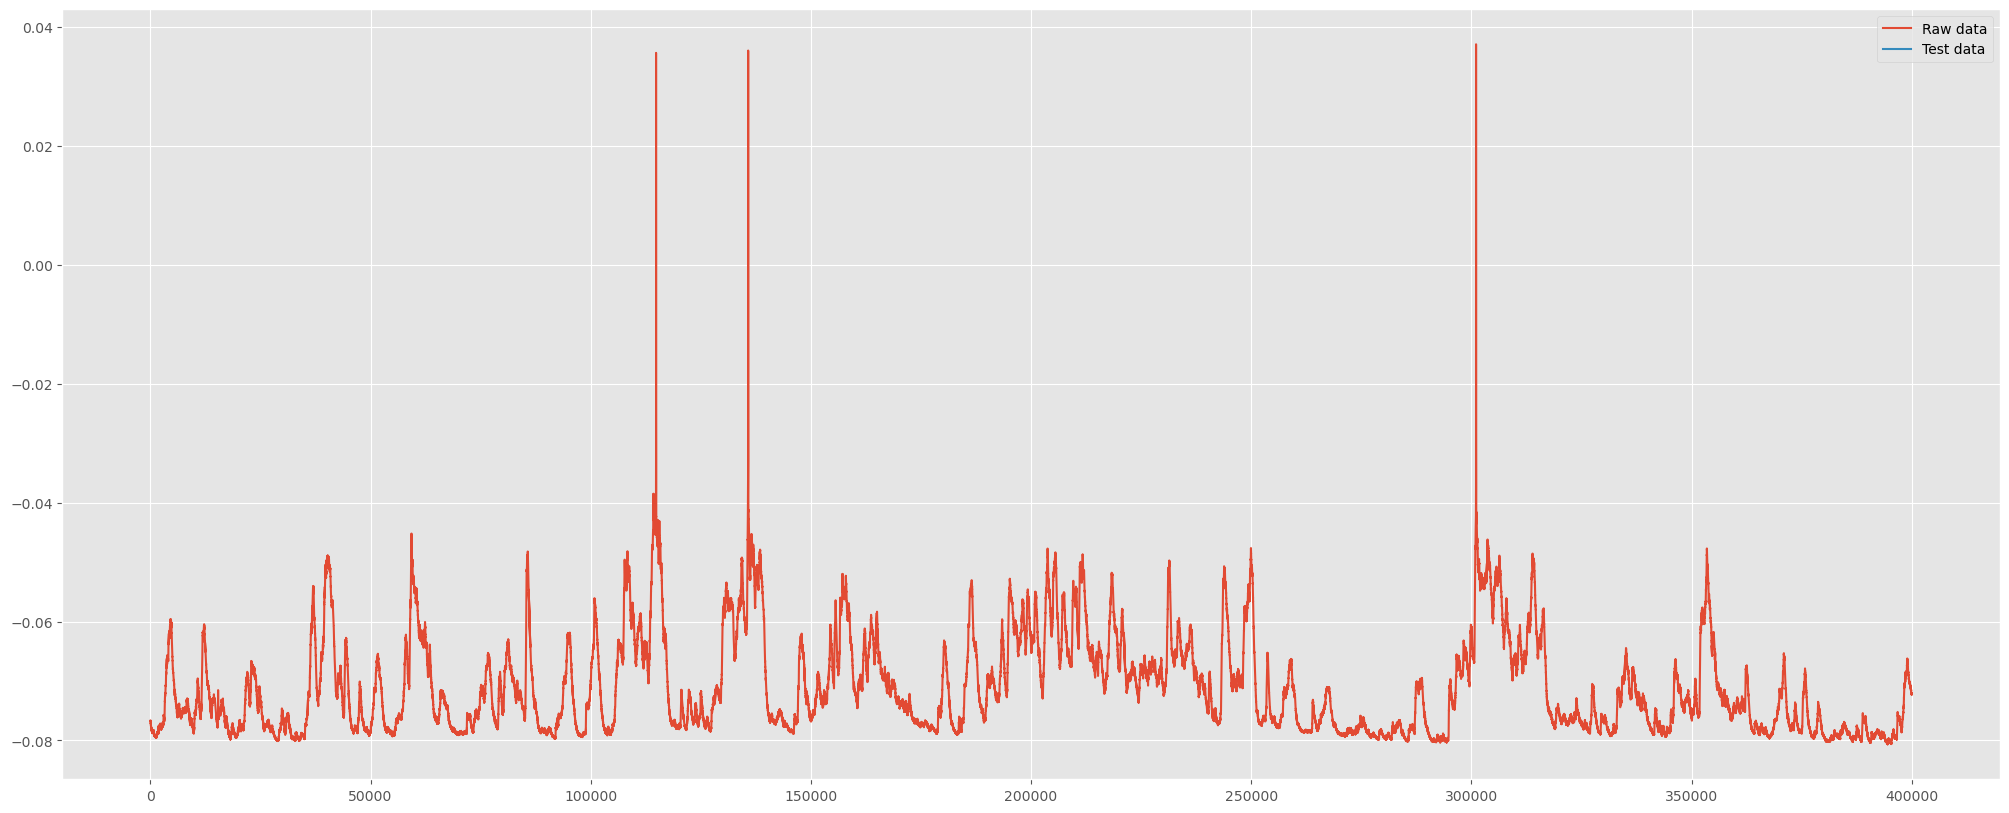

In [11]:

lowcut = 20
highcut = 200
filtered_df = butter_bandpass_filter(data=Vm, lowcut=lowcut, highcut=highcut, fs=sampling_rate)
display(filtered_df)

Vm_testplot(Vm, filtered_df)


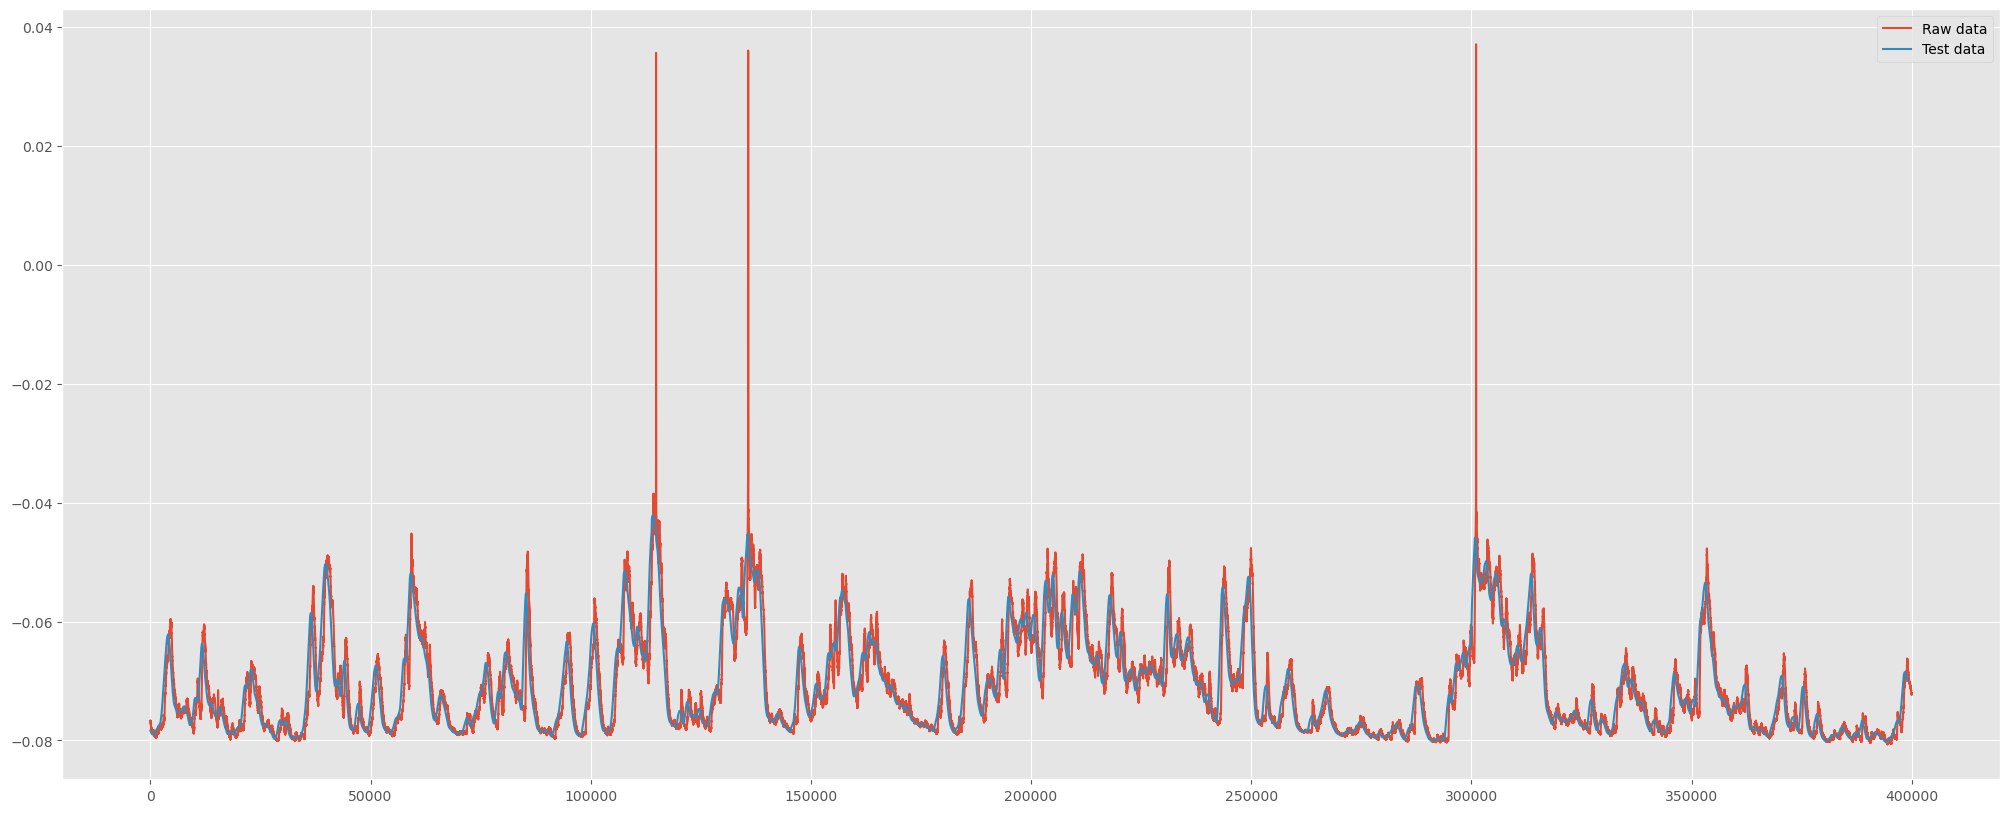

In [12]:
window_size = 1000
flt_data = np.convolve(Vm, np.ones(window_size), 'valid') / window_size

Vm_testplot(Vm, flt_data)

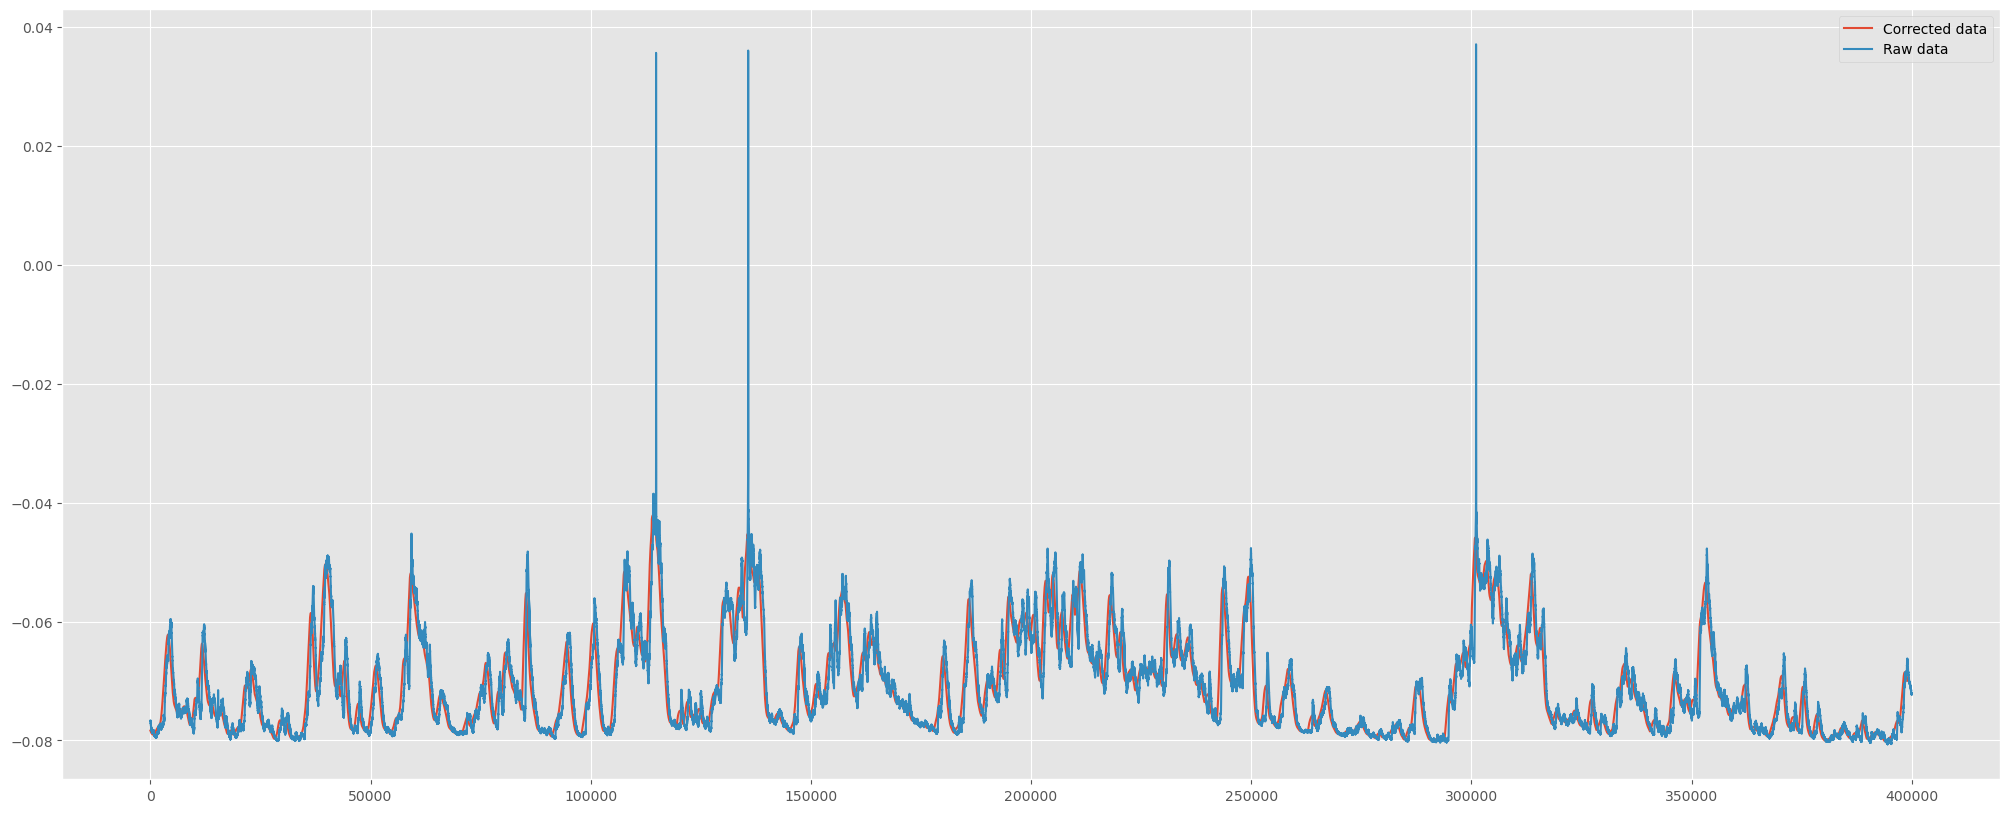

In [13]:

filtered_df = np.convolve(cells_df.Sweep_MembranePotential.iloc[cell], np.ones(window_size), 'valid') / window_size

plt.figure(figsize=(25,10))
plt.plot(filtered_df, label='Corrected data')
plt.plot(cells_df.Sweep_MembranePotential.iloc[cell], label='Raw data')
plt.legend()

In [14]:
ap_params = Function_Detect_APs(cells_df.Sweep_MembranePotential.iloc[0], 2000, cells_df.Cell_APThreshold_Slope.iloc[cell])

display(ap_params, cells_df.Cell_APThreshold_Slope.iloc[cell]), cells_df.Sweep_MembranePotential.iloc[cell]

[] dd


array([], shape=(0, 6), dtype=float64)

10.0

(None,
 array([-0.07665938, -0.07663125, -0.07661563, ..., -0.07209688,
        -0.07209375, -0.0721    ]))

In [15]:
from scipy.signal import find_peaks

def find_spikelet(MembranePotential, SR_Vm, Vm_Deriv_Thrs):
    Vm_Deriv_Thrs /= 4
    Max_Vm_Deriv = 0.1  # Set a maximum Vm_Deriv value
    
    AP_Win = 0.0015  # time (s) to search for AP's peak
    Min_AP_Amp = 0.0001  # Minimum AP amplitude (V)
    spike_length = np.round(AP_Win * SR_Vm)
    Vm_Deriv = np.diff(MembranePotential) * SR_Vm
    spike_Thrs_Onset = np.diff(np.divide(Vm_Deriv - Vm_Deriv_Thrs, np.abs(Vm_Deriv - Vm_Deriv_Thrs)))
    Vm_Med = np.median(MembranePotential)
    All_spikes_index, Peaks = find_peaks(spike_Thrs_Onset, height=0.01, prominence=0.1, distance=SR_Vm * 0.001)
    AP_index, APeaks = find_peaks(MembranePotential, height=0.1,prominence=0.5 , distance=SR_Vm * 0.001)
    
    # Calculate duration of big spikes
    big_spikes_duration = []
    big_spikes_index = []
    for spike_index in AP_index:
        half_amplitude = MembranePotential[spike_index] / 2
        half_amplitude_start = np.where(MembranePotential[:spike_index] <= half_amplitude)[0][-1]
        half_amplitude_end = np.where(MembranePotential[spike_index:] <= half_amplitude)[0][0] + spike_index
        duration = (half_amplitude_end - half_amplitude_start) / SR_Vm
        big_spikes_duration.append(duration)
        big_spikes_index.extend(range(half_amplitude_start-100000, half_amplitude_end + 100000))
    '''
        ap_params = Function_Detect_APs(MembranePotential, SR_Vm, Vm_Deriv_Thrs)
        ap_times = list(map(int, ap_params[2]*SR_Vm))
        ap_duration = list(map(int, ap_params[5]*SR_Vm))
        
        big_spikes_index = []
        for spike_index in ap_times:
            half_amplitude = MembranePotential[spike_index] / 2
            half_amplitude_start = np.where(MembranePotential[:spike_index] <= half_amplitude)[0][-1]
            half_amplitude_end = np.where(MembranePotential[spike_index:] <= half_amplitude)[0][0] + spike_index
            big_spikes_index.extend(range(ap_duration, ap_duration + 1))
        
        small_spikes_index = [i for i in All_spikes_index if i not in big_spikes_index]
    '''
    small_spikes_index = [i for i in All_spikes_index if i not in big_spikes_index and Vm_Deriv[i] <= Max_Vm_Deriv]
    
    return small_spikes_index

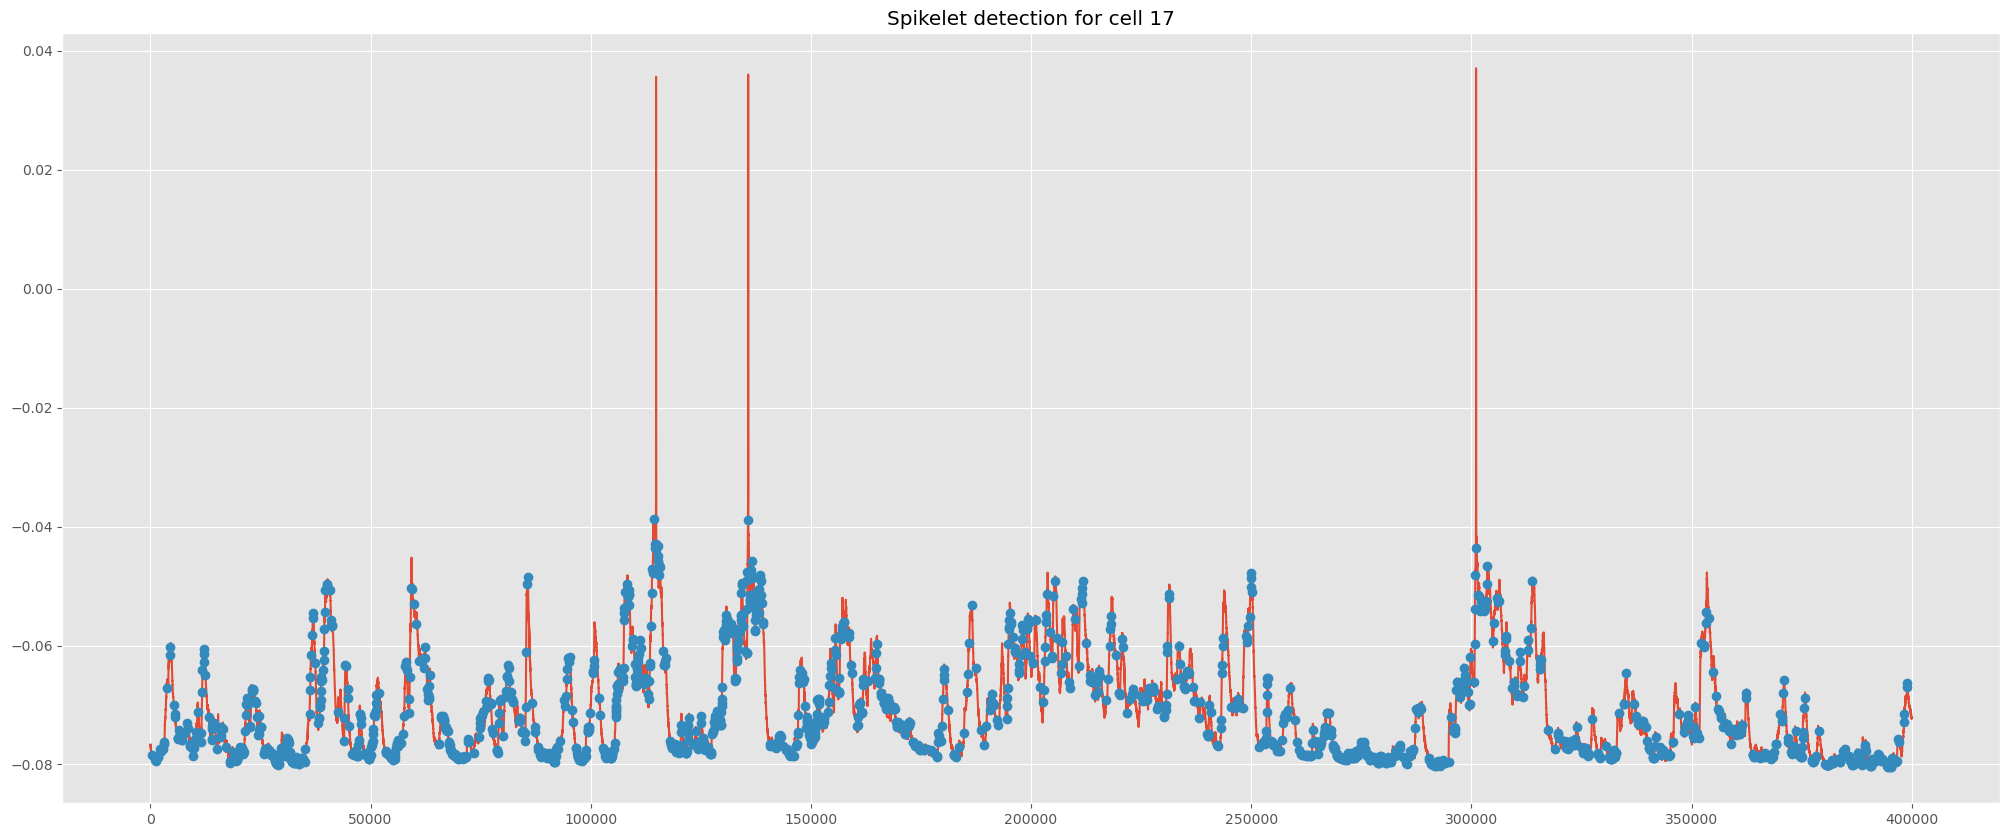

In [16]:


spikelet_index = find_spikelet(cells_df.Sweep_MembranePotential.iloc[cell], 20000, cells_df.Cell_APThreshold_Slope.iloc[cell])

plt.figure(figsize=(25,10))

plt.plot(cells_df.Sweep_MembranePotential.iloc[cell])
plt.plot(spikelet_index, cells_df.Sweep_MembranePotential.iloc[cell][spikelet_index], 'o')

plt.title(f'Spikelet detection for cell {cell}')
plt.show()




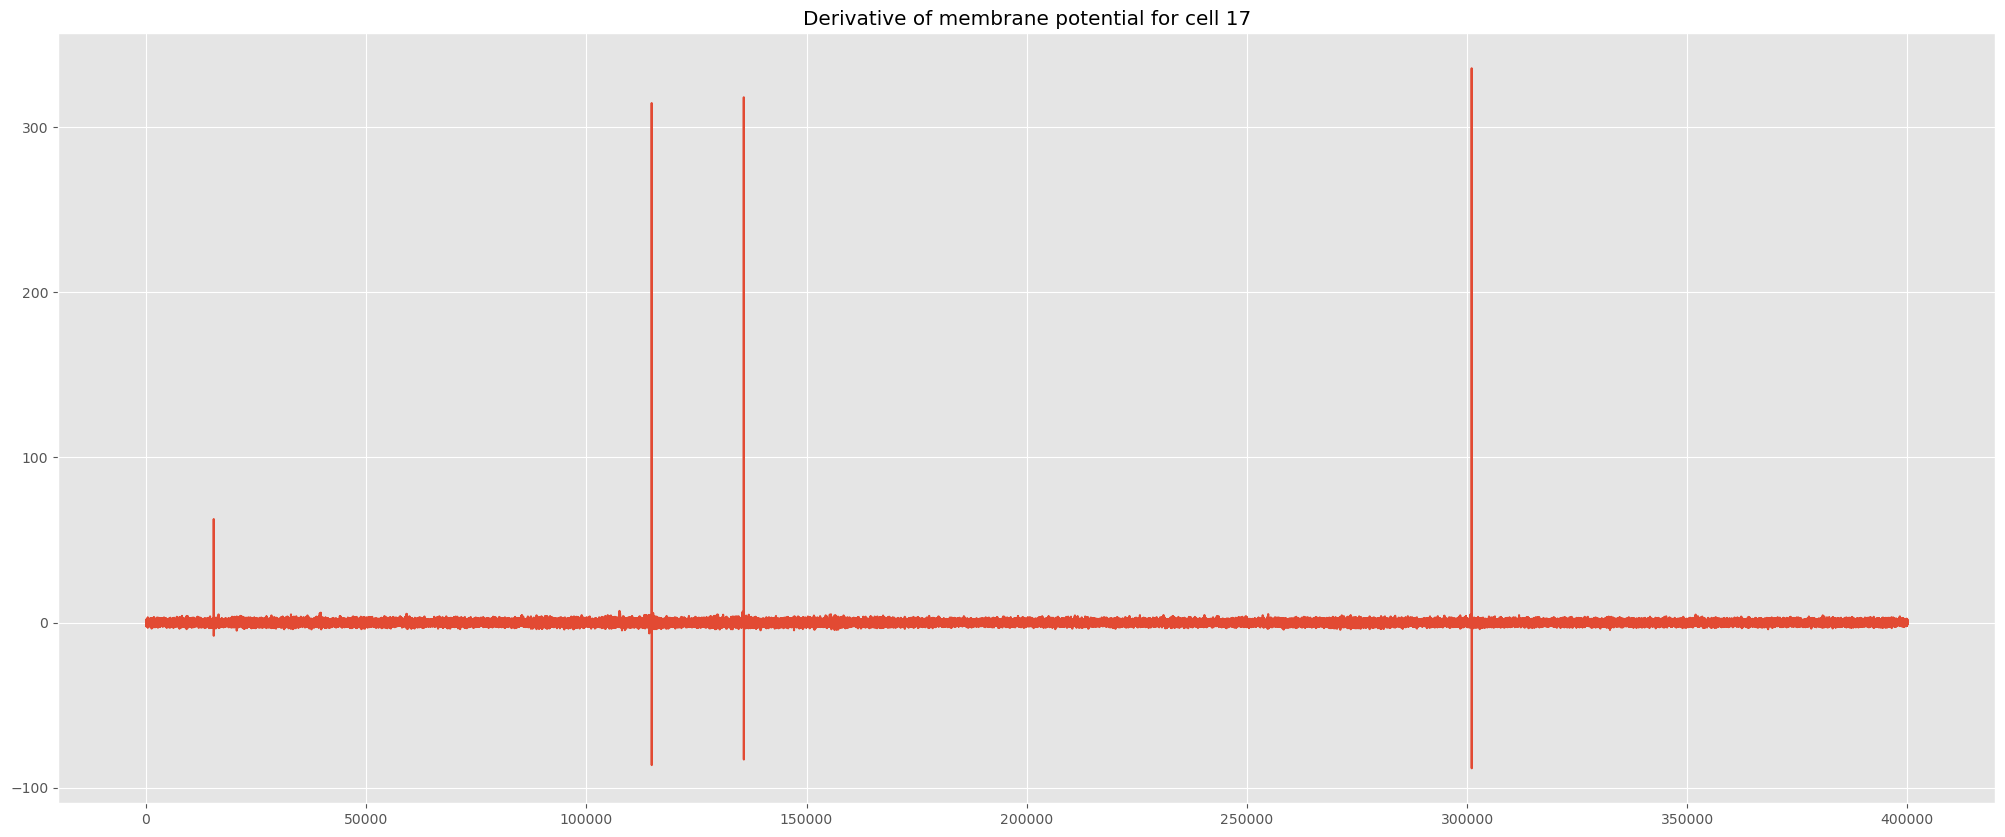

In [17]:
#plot the derivative of membrane potential

plt.figure(figsize=(25,10))
plt.plot(np.diff(cells_df.Sweep_MembranePotential.iloc[cell])*20000)
plt.title(f'Derivative of membrane potential for cell {cell}')
plt.show()

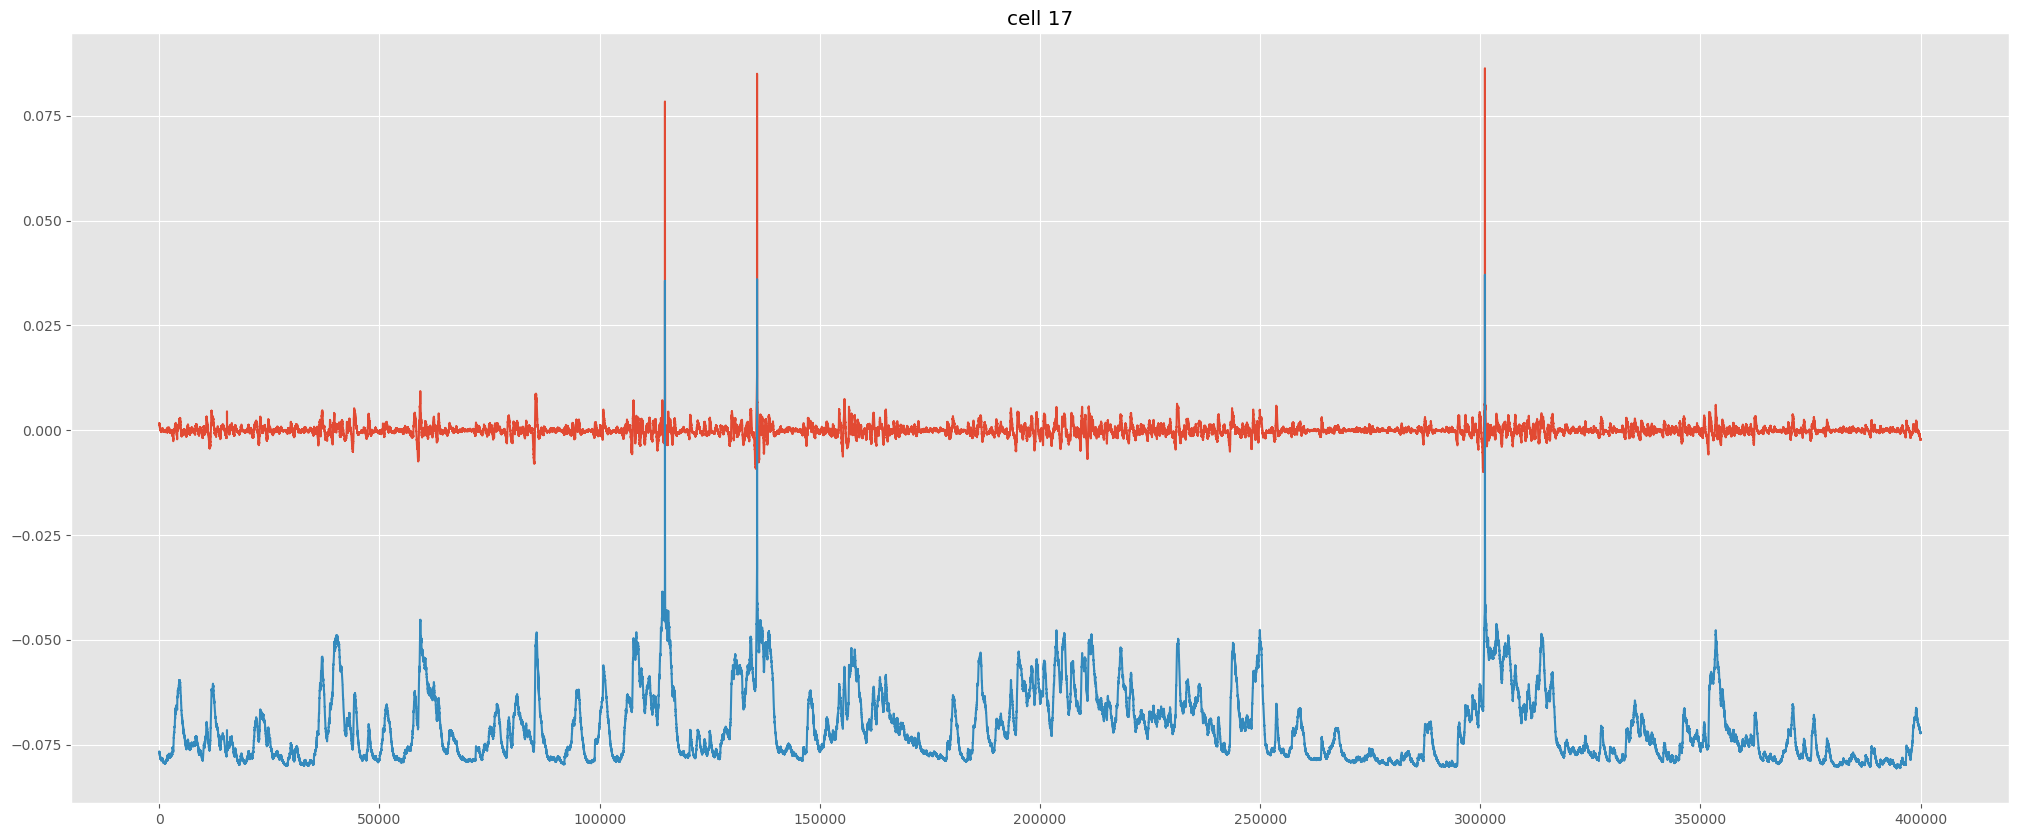

In [18]:

'''

*******************************************************************************************

'''

# Calculate the moving average
window_size = 1000
moving_avg = np.convolve(Vm, np.ones(window_size), 'valid') / window_size

# Extend the moving average array to the same size as the original data
moving_avg = np.concatenate((np.full(window_size//2, moving_avg[0]), moving_avg, np.full(window_size//2, moving_avg[-1])))

# Subtract the moving average from the original data to locally normalize it
normalized_Vm = Vm - moving_avg[:-1]

# Plot the normalized data
plt.figure(figsize=(25,10))
plt.plot(normalized_Vm)
plt.plot(Vm)
plt.title(f'cell {cell}')
plt.show()

In [19]:
#iterative thresholding to find spikelets

def find_spikelets_iterative(MembranePotential, window_size, num_std, target_num_spikelets, max_spike_height):
    # Initialize the number of spikelets
    num_spikelets = 0
    local_thresholds = []
    # Iterate over the membrane potential
    for i in range(window_size, len(MembranePotential) - window_size):
        # Calculate the local threshold based on the mean and standard deviation within the window
        local_mean = np.mean(MembranePotential[i-window_size:i+window_size])
        local_std = np.std(MembranePotential[i-window_size:i+window_size])
        local_threshold = local_mean + num_std * local_std
        # If the membrane potential at the current point is above the local threshold and below the max_spike_height, it's a spikelet
        if local_threshold < MembranePotential[i] :
            num_spikelets += 1
            
        local_thresholds.append(local_threshold)
        
        # If we've found the target number of spikelets, stop iterating
        if num_spikelets >= target_num_spikelets:
            break
    
    return num_spikelets, local_thresholds

In [20]:

target_num_spikelets = 100  # Example value, adjust based on your data
max_spike_height = -0.02  # Example value, adjust based on your data
window_size = 1000  # Example value, adjust based on your data
num_std = 1  # Example value, adjust based on your data

spikelets_index, local_thresholds = find_spikelets_iterative(
    MembranePotential=cells_df.Sweep_MembranePotential[cell], 
    window_size=window_size, 
    num_std=num_std, 
    target_num_spikelets=target_num_spikelets, 
    max_spike_height=max_spike_height)



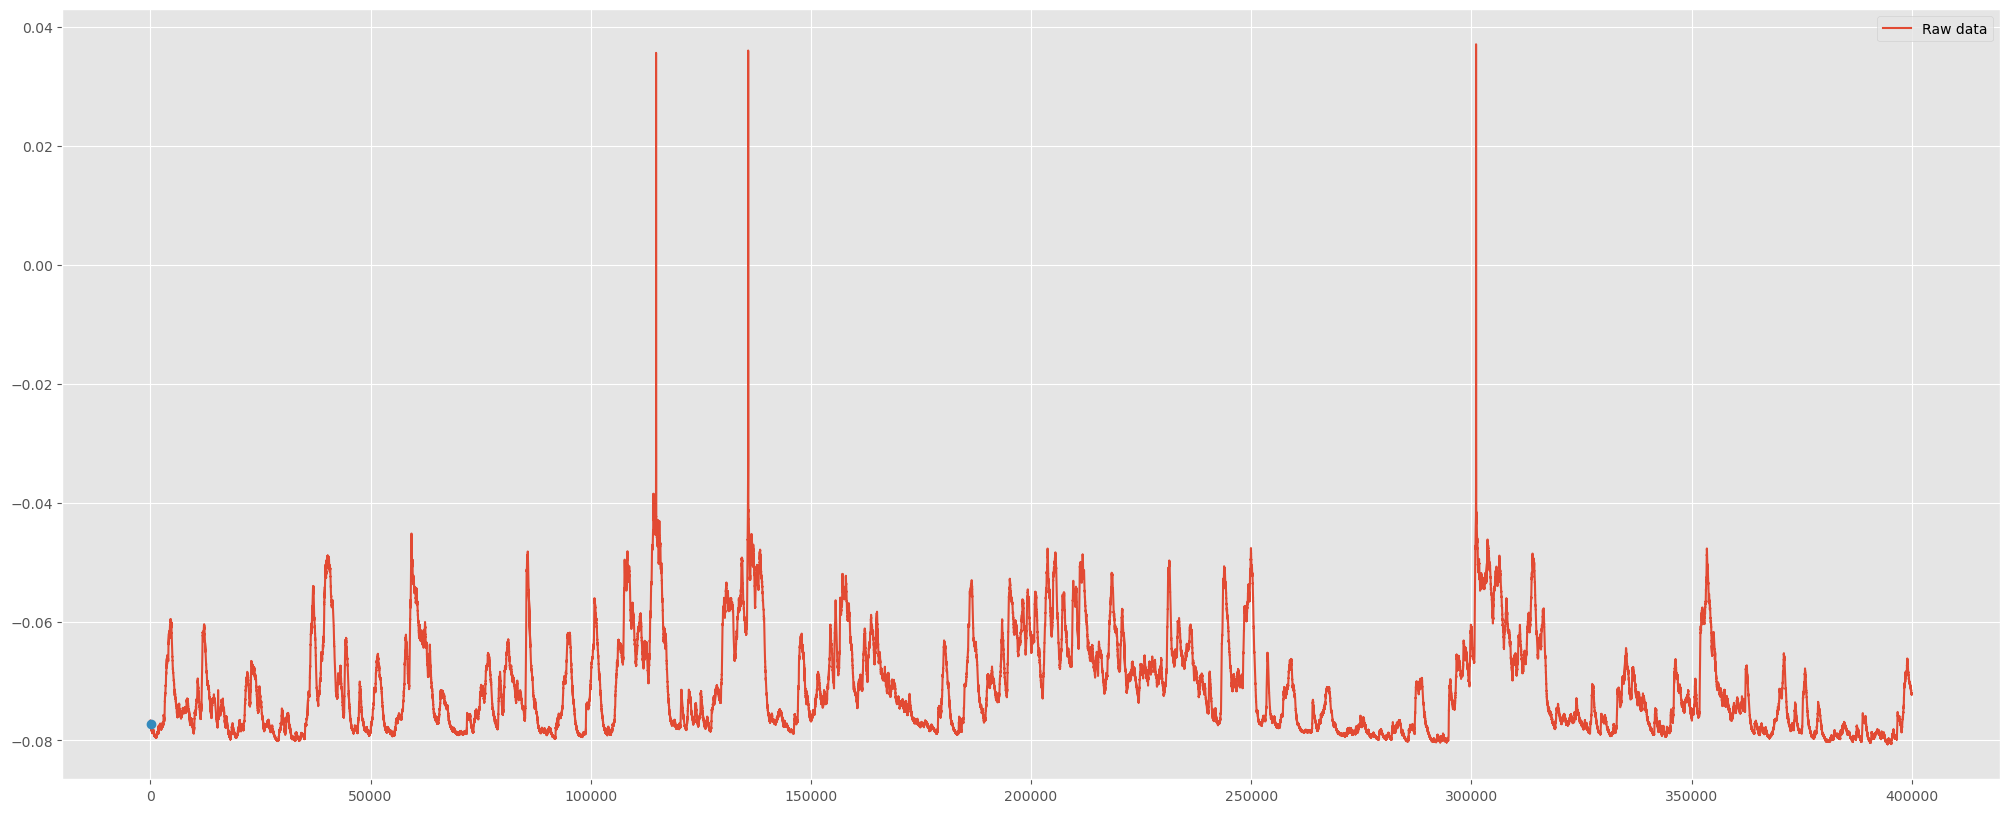

In [21]:

spikelet_testplot(Vm, spikelets_index)


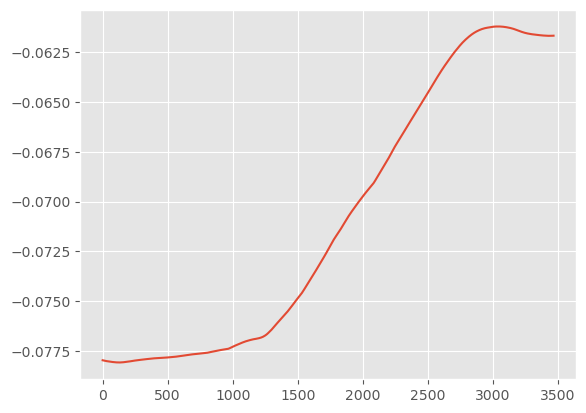

In [22]:
plt.plot(local_thresholds, label='Local threshold')
plt.show()


In [23]:

def find_spikelets_local_threshold(MembranePotential, window_size, num_std, max_spike_height):
    # Initialize the list of spikelet indices
    spikelets_index = []
    local_thresholds = []
    min_spike_height = Vm.mean() + 0.5 * Vm.std()
    
    # Iterate over the membrane potential
    for i in range(window_size, len(MembranePotential) - window_size):
        # Calculate the local threshold based on the mean and standard deviation within the window
        local_mean = np.mean(MembranePotential[i-window_size:i+window_size])
        local_std = np.std(MembranePotential[i-window_size:i+window_size])
        
        if local_mean < min_spike_height:
            local_threshold = min_spike_height
        else:
            local_threshold = local_mean + num_std * local_std
            
        local_thresholds.append(local_threshold)
        
        # If the membrane potential at the current point is above the local threshold and below the max_spike_height, it's a spikelet
        if local_threshold < MembranePotential[i] < max_spike_height:
            spikelets_index.append(i)

    return spikelets_index, local_thresholds

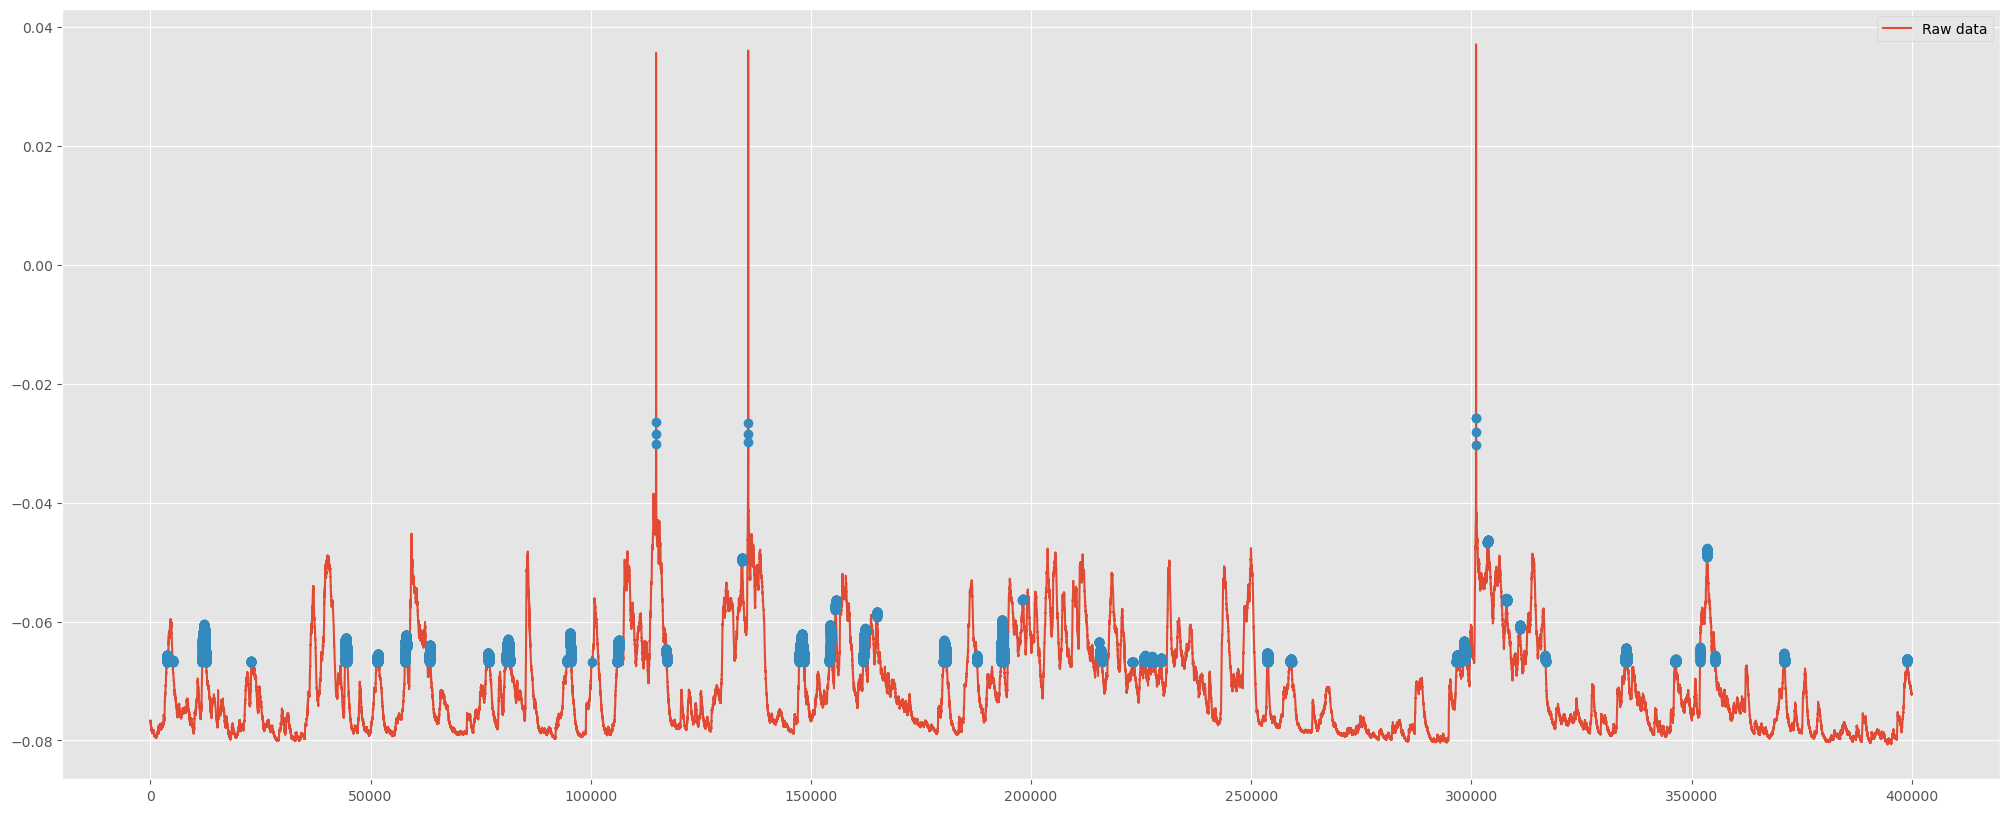

In [24]:

max_spike_height = -0.025  # Example value, adjust based on your data
window_size = 1000  # Example value, adjust based on your data
num_std = 2  # Example value, adjust based on your data

spikelets_index, local_thresholds = find_spikelets_local_threshold(
    MembranePotential=Vm, 
    window_size=window_size, 
    num_std=num_std, 
    max_spike_height=max_spike_height)

spikelet_testplot(Vm, spikelets_index)

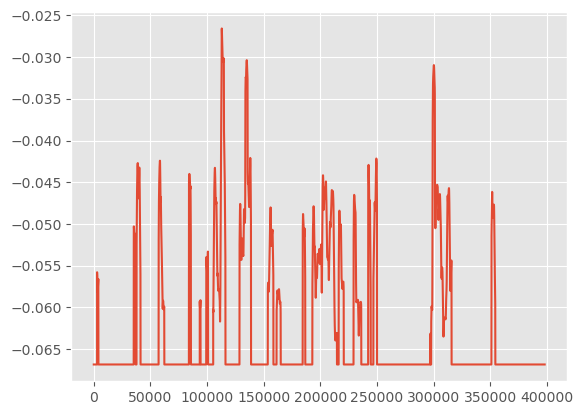

In [25]:
plt.plot(local_thresholds, label='Local threshold')
plt.show()


In [26]:

def find_spikelets_local_threshold(MembranePotential, SR_Vm, window_size, num_std, max_spike_deriv):
    # Calculate the derivative of the membrane potential
    Vm_Deriv = np.diff(MembranePotential) * SR_Vm

    # Find the indices of the big spikes in the derivative of the membrane potential
    big_spikes_index, _ = find_peaks(Vm_Deriv, height=max_spike_deriv, prominence=0.5, distance=SR_Vm * 0.001)

    # Initialize the list of spikelet indices
    spikelets_index = []
    local_thresholds = []
    
    # Iterate over the membrane potential
    for i in range(window_size, len(MembranePotential) - window_size):
        # Skip the big spikes
        if i in big_spikes_index:
            continue

        # Calculate the local threshold based on the mean and standard deviation within the window
        local_mean = np.mean(MembranePotential[i-window_size:i+window_size])
        local_std = np.std(MembranePotential[i-window_size:i+window_size])
        local_threshold = local_mean + num_std * local_std
        
        local_thresholds.append(local_threshold)
        
        # If the membrane potential at the current point is above the local threshold, it's a spikelet
        if local_threshold < MembranePotential[i]:
            spikelets_index.append(i)

    return spikelets_index, local_thresholds

In [27]:
def find_spikelets_local_threshold(MembranePotential, SR_Vm, window_size, num_std, min_spike_deriv, max_spike_deriv):
    # Calculate the derivative of the membrane potential
    Vm_Deriv = np.diff(MembranePotential) * SR_Vm

    # Find the indices of the big spikes (APs) in the derivative of the membrane potential
    APs_index, _ = find_peaks(Vm_Deriv, height=max_spike_deriv, prominence=0.5, distance=SR_Vm * 0.001)

    # Find the indices of the small spikes (spikelets) in the derivative of the membrane potential
    spikelets_index, _ = find_peaks(Vm_Deriv, height=(min_spike_deriv, max_spike_deriv), prominence=0.5, distance=SR_Vm * 0.001)

    # Remove the APs from the spikelets
    spikelets_index = np.setdiff1d(spikelets_index, APs_index)

    # Initialize the list of local thresholds
    local_thresholds = []

    # Iterate over the spikelets
    for i in spikelets_index:
        # Calculate the local threshold based on the mean and standard deviation within the window
        local_mean = np.mean(MembranePotential[max(0, i-window_size):min(len(MembranePotential), i+window_size)])
        local_std = np.std(MembranePotential[max(0, i-window_size):min(len(MembranePotential), i+window_size)])
        local_threshold = local_mean + num_std * local_std

        local_thresholds.append(local_threshold)

    return spikelets_index, local_thresholds

In [28]:
min_spike_deriv = 0.1  # Example value, adjust based on your data
max_spike_height = -0.025  # Example value, adjust based on your data
window_size = 1000  # Example value, adjust based on your data
num_std = 2  # Example value, adjust based on your data

spikelets_index, local_thresholds = find_spikelets_local_threshold(
    MembranePotential=Vm, 
    window_size=window_size, 
    num_std=num_std,
    SR_Vm=20000,
    max_spike_deriv=deriv_thresh,
    )

spikelet_testplot(Vm, spikelets_index)

TypeError: find_spikelets_local_threshold() missing 1 required positional argument: 'min_spike_deriv'

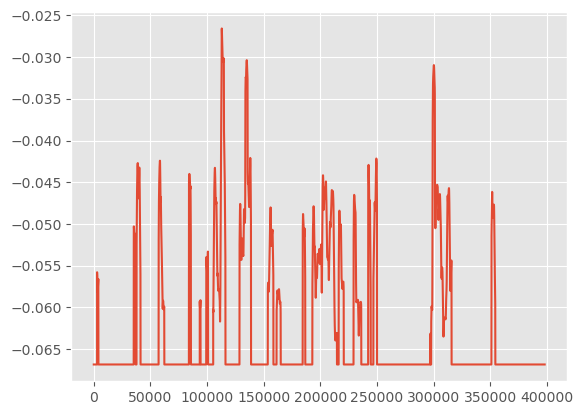

In [29]:
plt.plot(local_thresholds, label='Local threshold')
plt.show()


In [30]:
def Function_Detect_Spikelets(MembranePotential, SR_Vm, min_threshold, max_threshold):
    """
    Detects spikelets in a given membrane potential trace.

    Parameters:
    MembranePotential (numpy array): The membrane potential trace.
    SR_Vm (float): The sampling rate of the membrane potential trace.
    min_threshold (float): The minimum threshold for the membrane potential.
    max_threshold (float): The maximum threshold for the membrane potential.

    Returns:
    spikelets_index (numpy array): An array of the indices of the spikelets in the membrane potential trace.
    """
    # Calculate the derivative of the membrane potential
    Vm_Deriv = np.diff(MembranePotential) * SR_Vm
    AP_Win = 0.0015
    AP_length = np.round(AP_Win * SR_Vm)
    Vm_Deriv = np.diff(MembranePotential) * SR_Vm
    
    AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - min_threshold, np.abs(Vm_Deriv - min_threshold)) * np.divide(Vm_Deriv - max_threshold, np.abs(Vm_Deriv - max_threshold)))    
    
    Vm_Med = np.median(MembranePotential)
    spikelets_index, Peaks = find_peaks(AP_Thrs_Onset, height=0.1, prominence=0.5, distance=SR_Vm * 0.001)
    
    # Find the indices of the spikelets in the derivative of the membrane potential
    #spikelets_index, _ = find_peaks(Vm_Deriv, height=(min_threshold, max_threshold))

    return spikelets_index

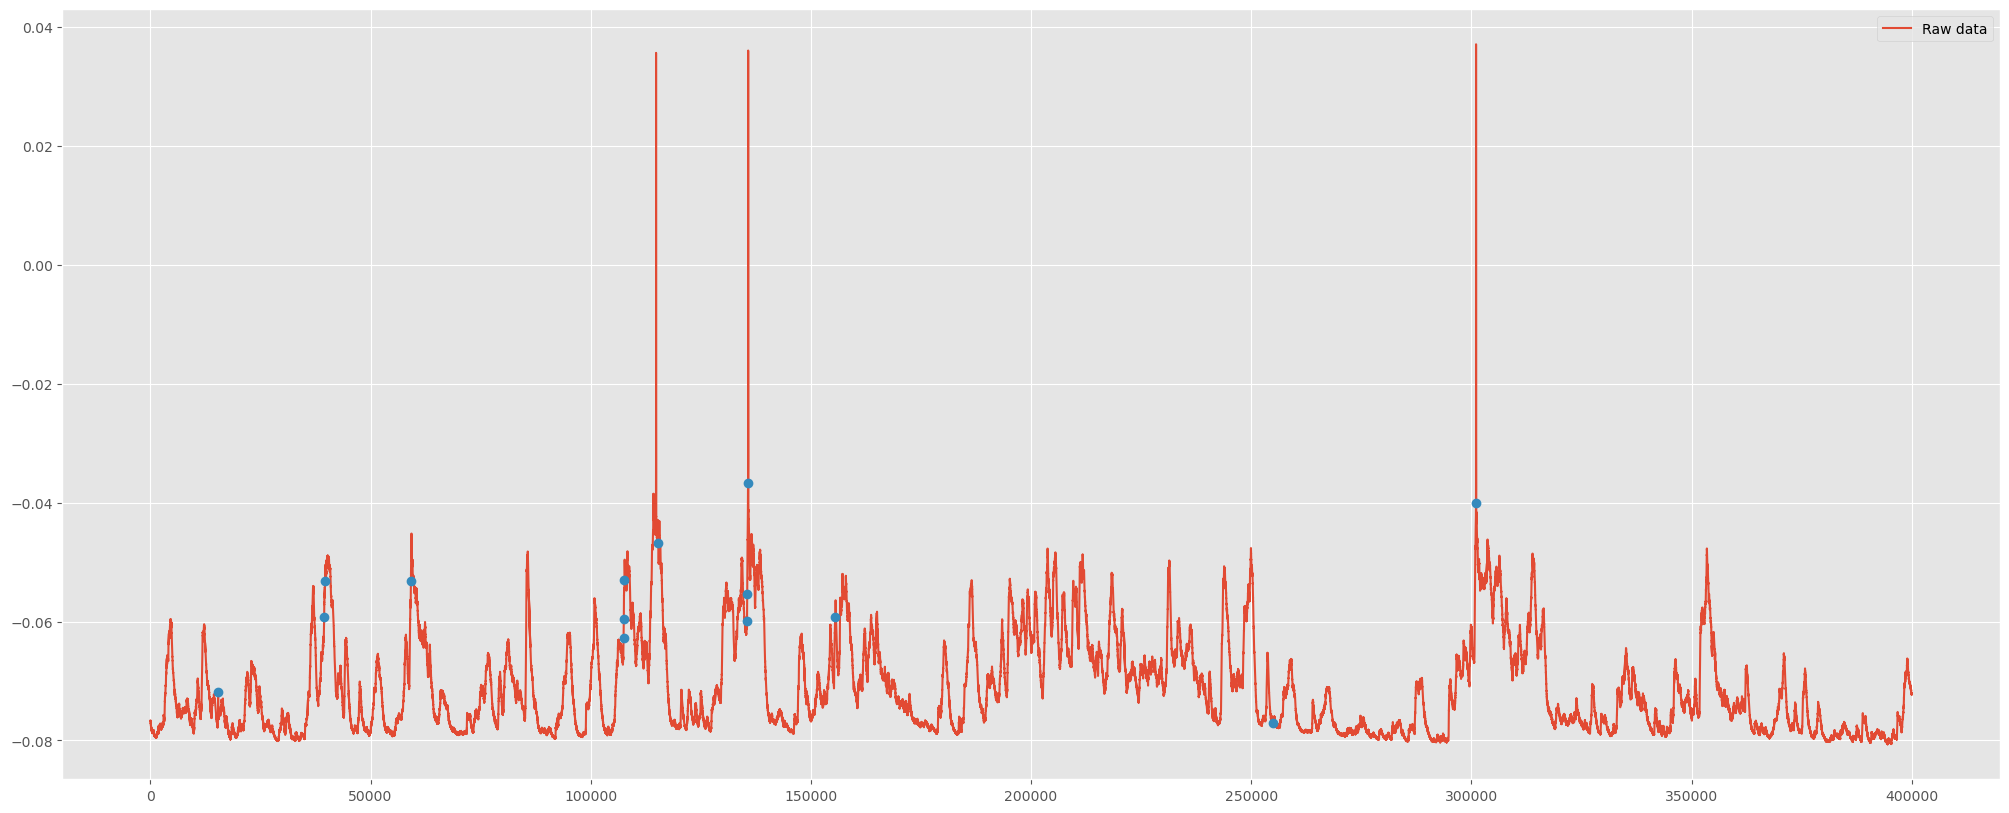

In [31]:
min_threshold = cells_df.Cell_APThreshold_Slope.iloc[cell]*0.5
max_threshold = cells_df.Cell_APThreshold_Slope.iloc[cell]  

spikelets_index = Function_Detect_Spikelets(Vm, sampling_rate, min_threshold, max_threshold)

spikelet_testplot(Vm, spikelets_index)

In [32]:
def Function_Detect_spikelets(MembranePotential, SR_Vm, max_threshold, min_threshold):
    """
    Detects action potentials (APs) in a given membrane potential trace.

    Parameters:
    MembranePotential (numpy array): The membrane potential trace.
    SR_Vm (float): The sampling rate of the membrane potential trace.
    Vm_Deriv_Thrs (float): The threshold for the derivative of the membrane potential.

    Returns:
    AP_Param_Output (numpy array): A 2D array where each row represents an AP and the columns represent:
        0: Threshold time of the AP
        1: Membrane potential at the threshold
        2: Peak time of the AP
        3: Membrane potential at the peak
        4: Amplitude of the AP
        5: Duration of the AP at half amplitude
    """
    # Parameters
    AP_Param_Output = []
    AP_Win = 0.0015  # time (s) to search for AP's peak
    Min_AP_Amp = 0.005  # Minimum AP amplitude (V)
    AP_length = np.round(AP_Win * SR_Vm)
    Vm_Deriv = np.diff(MembranePotential) * SR_Vm
    AP_Thrs_Onset = np.diff(np.divide(Vm_Deriv - min_threshold, np.abs(Vm_Deriv - min_threshold)) * np.divide(Vm_Deriv - max_threshold, np.abs(Vm_Deriv - max_threshold)))    
    Vm_Med = np.median(MembranePotential)
    AP_Thrs_Index, Peaks = find_peaks(AP_Thrs_Onset, height=0.1, prominence=0.5, distance=SR_Vm * 0.001)

    AP_Param_Output = np.empty([len(AP_Thrs_Index), 6])
    AP_Param_Output[:] = np.nan

    if (AP_Thrs_Index.any()):
        AP_cnt = 0
        for i in range(len(AP_Thrs_Index)):
            pt1 = int(AP_Thrs_Index[i])
            pt2 = int(AP_Thrs_Index[i] + AP_length)

            if (pt2 < len(MembranePotential) - 1):  # remove -1?
                AP_Seg = MembranePotential[pt1:pt2]
                Ind = np.argmax(AP_Seg)
                if (Ind.any()):
                    AP_Index = pt1 + Ind - 1  # remove -1?
                    AP_Amp = MembranePotential[AP_Index] - MembranePotential[pt1]
                    if ((AP_Amp > Min_AP_Amp) & (MembranePotential[AP_Index] > Vm_Med)):
                        AP_Param_Output[AP_cnt, 0] = AP_Thrs_Index[i] / SR_Vm  # Thrs Time
                        AP_Param_Output[AP_cnt, 1] = MembranePotential[AP_Thrs_Index[i]]  # Thrs Vm
                        AP_Param_Output[AP_cnt, 2] = AP_Index / SR_Vm  # Peak Time
                        AP_Param_Output[AP_cnt, 3] = MembranePotential[AP_Index]  # Peak Vm
                        AP_Param_Output[AP_cnt, 4] = AP_Amp  # Peak Amp
                        Ind = AP_Thrs_Index[i]
                        pt2 = AP_Index
                        # we define a time window for the AP ...
                        pt1 = int(AP_Thrs_Index[i])  # ... AP threshold index ...
                        pt3 = int(pt2 + (0.005 * SR_Vm))  # ... and 3 ms after the peak.
                        if (pt1 > 0 & pt3 < len(MembranePotential)):
                            Vm_HalfAmp = MembranePotential[Ind] + AP_Amp / 2  # Vm at half amplitude
                            sAP_Seg = MembranePotential[pt1:pt3]  # cut a segment of the VM that contains the AP
                            sAP_Seg = sAP_Seg - Vm_HalfAmp  # substract the Vm at half-amplitude
                            sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
                            sAP_Indmax = np.argmax(sAP_OnOff)  # identify index begening AP at half amplitude
                            sAP_Indmin = np.argmin(sAP_OnOff)  # identify index end AP at half amplitude
                            
                            if np.min(sAP_OnOff)>-1:
                                sAP_Indmin=len(sAP_Seg)

                            AP_Param_Output[AP_cnt, 5] = ((sAP_Indmin - sAP_Indmax) / SR_Vm) * 1000  # compute duration at half-amplitude
                        else:
                            AP_Param_Output[AP_cnt, 5] = np.nan
                        AP_cnt = AP_cnt + 1

    if (AP_Param_Output.any()):
        Amp_Lim_Inf = min([np.median(AP_Param_Output[:, 4]) - (5 * np.std(AP_Param_Output[:, 4])), 0.03])
        Peak_Lim_Inf = np.min([np.median(AP_Param_Output[:, 3]) - 5 * np.std(AP_Param_Output[:, 3]), -0.02])
        cnt_Max = len(AP_Param_Output)
        for i in range(cnt_Max):
            cnt = cnt_Max - i - 1
            if ((AP_Param_Output[cnt, 4] < Amp_Lim_Inf) & (AP_Param_Output[cnt, 3] < Peak_Lim_Inf)):
                # AP_Param[cnt,:]=np.empty([1, 6])
                AP_Param_Output = np.delete(AP_Param_Output, cnt, 0)
    print(AP_Param_Output, 'dd')
    AP_Param_Output = AP_Param_Output[~np.isnan(AP_Param_Output).all(axis=1), :]

    return AP_Param_Output

In [33]:
min_threshold = cells_df.Cell_APThreshold_Slope.iloc[cell]*0.4
max_threshold = cells_df.Cell_APThreshold_Slope.iloc[cell]*0.7  


spikelets = df_ap_converter(Function_Detect_spikelets(Vm, sampling_rate, max_threshold, min_threshold))

display(spikelets)

[[ 5.7407500e+00 -3.8531250e-02  5.7416000e+00  3.4940625e-02
   7.3471875e-02  8.5000000e-01]
 [ 6.7746000e+00 -5.8887500e-02  6.7760000e+00 -5.3571875e-02
   5.3156250e-03  5.8500000e+00]
 [ 6.7870000e+00 -3.6981250e-02  6.7875000e+00  3.5159375e-02
   7.2140625e-02  8.5000000e-01]
 [ 1.5050850e+01 -4.2462500e-02  1.5052250e+01  7.0000000e-03
   4.9462500e-02  1.1000000e+00]
 [ 1.5051950e+01 -3.8156250e-02  1.5052450e+01  3.6446875e-02
   7.4603125e-02  8.0000000e-01]
 [           nan            nan            nan            nan
             nan            nan]
 [           nan            nan            nan            nan
             nan            nan]
 [           nan            nan            nan            nan
             nan            nan]
 [           nan            nan            nan            nan
             nan            nan]
 [           nan            nan            nan            nan
             nan            nan]
 [           nan            nan            nan    

,ap_thresh_times,ap_thresh_vm,ap_peak_times,ap_peak_vm,ap_amp,ap_duration
0,5.74075,-0.038531,5.74160,0.034941,0.073472,0.85
1,6.77460,-0.058888,6.77600,-0.053572,0.005316,5.85
2,6.78700,-0.036981,6.78750,0.035159,0.072141,0.85
3,15.05085,-0.042463,15.05225,0.007000,0.049462,1.10
4,15.05195,-0.038156,15.05245,0.036447,0.074603,0.80


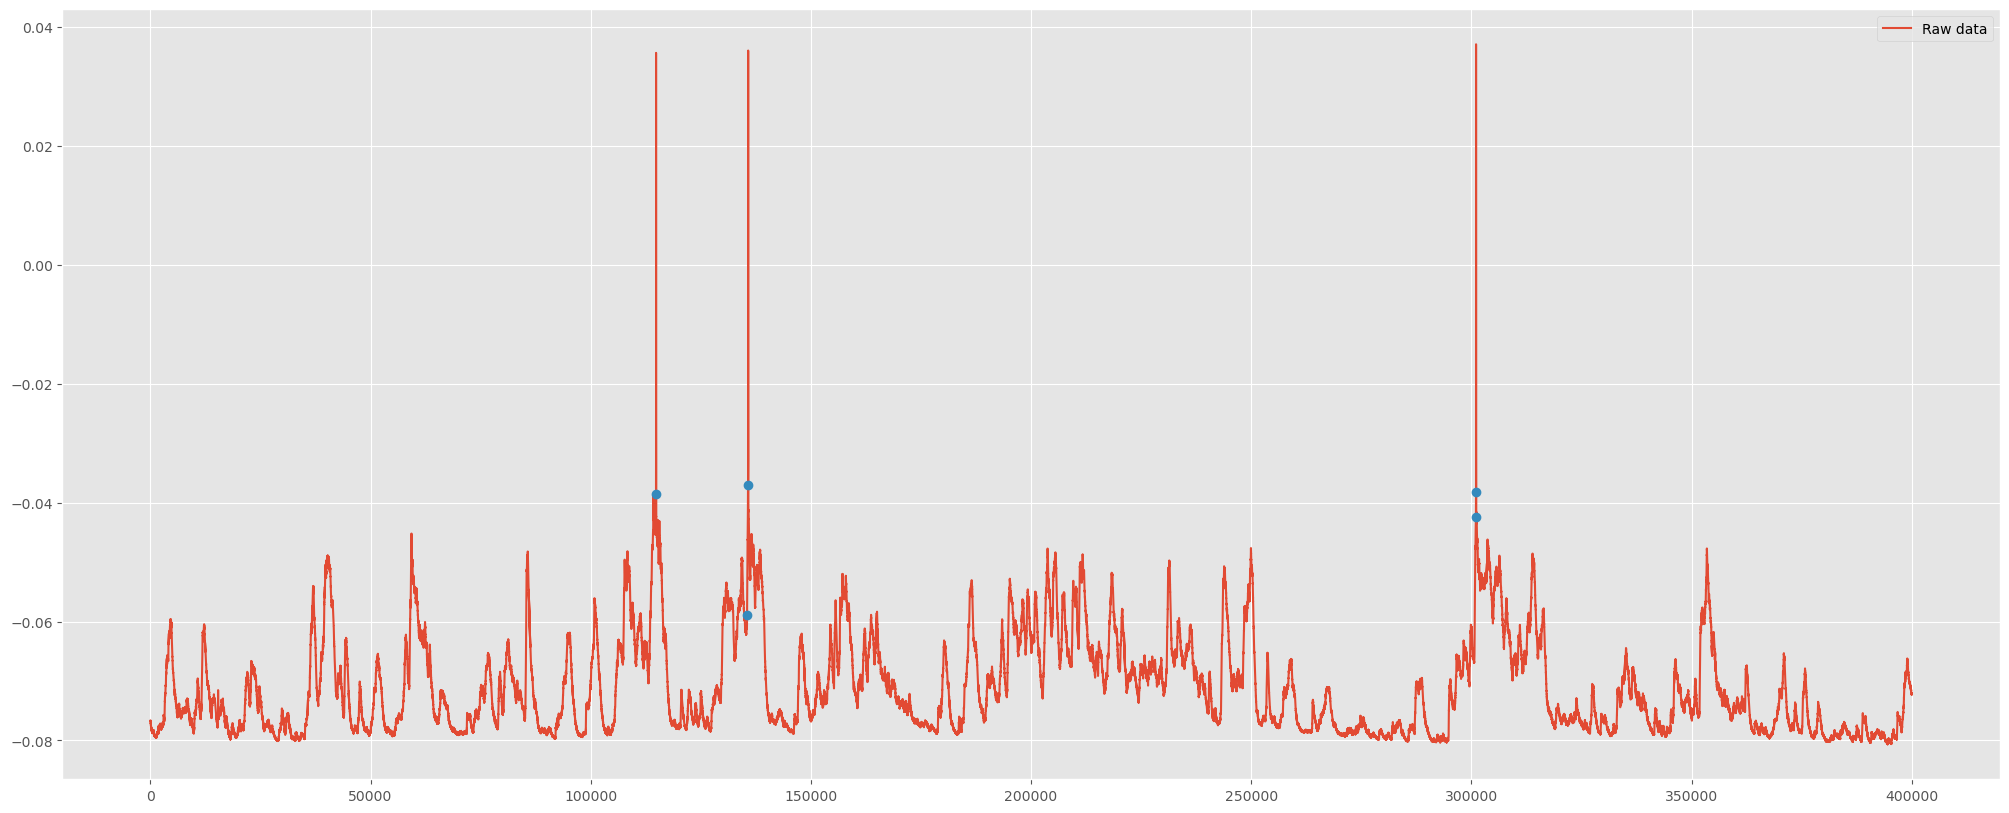

In [34]:
#Show the spikelets on the membrane potential trace
plt.figure(figsize=(25,10))
plt.plot(Vm, label='Raw data')
plt.plot(spikelets['ap_thresh_times']*sampling_rate, spikelets['ap_thresh_vm'], 'o')
plt.legend()

plt.show()

In [169]:

'''

*******************************************************************************************

'''
def moving_avg_normalise(data, mvg_avg_window = 800):
    # Calculate moving average
    moving_avg = np.convolve(data, np.ones(mvg_avg_window), 'valid') / mvg_avg_window
    
    # Extend the moving average array to the same size as the original data by padding
    pad_start = mvg_avg_window // 2
    pad_end = (mvg_avg_window - 1) // 2
    moving_avg = np.concatenate((np.full(pad_start, moving_avg[0]), moving_avg, np.full(pad_end, moving_avg[-1])))
    
    # Subtract the moving average from the original data to locally normalize it
    normalized_Vm = data - moving_avg
    
    return normalized_Vm

def lower_bound(data, mvg_avg_window = 800, sub_window_size=10000):
    
    normalized_Vm = moving_avg_normalise(data, mvg_avg_window)
    min_std = np.inf  # Initialize the minimum standard deviation to infinity
    min_std_start = None  # Initialize the start index of the window with the minimum standard deviation
    
    # I had to introduce a step to make the function more efficient
    step = sub_window_size // 500
    
    # For each possible window in Vm
    for start in range(0, len(normalized_Vm) - sub_window_size + 1, step):
        # Calculate the standard deviation of the window
        std = np.std(normalized_Vm[start : start + sub_window_size])
        # If this standard deviation is lower than the current minimum
        if std < min_std:
            # Update the minimum standard deviation and the start index of the window
            min_std = std
            min_std_start = start

    # The sub-dataset of Vm with the lowest standard deviation is Vm[min_std_start : min_std_start + window_size]
    quiescence = normalized_Vm[min_std_start : min_std_start + sub_window_size]

    # Calculate the standard deviation of the membrane potential during this period
    std_dev = np.std(quiescence)

    # Calculate the average standard deviation of the entire signal
    avg_std_dev = np.std(normalized_Vm)

    # Calculate the coefficient
    bound = (0*avg_std_dev + 5*std_dev)

    # Set the lower threshold
    return bound

def find_spikelet_moving_avg(Vm, Vm_thrs = -0.03, window_size= 1000, lower_threshold= 0.002, SR_Vm=20000):
    
    AP_Win = 0.0015  # time (s) to search for AP's peak
    AP_length = np.round(AP_Win * SR_Vm)

    normalized_Vm = moving_avg_normalise(Vm, window_size)
    
    All_Thrs_Onset = np.diff(np.divide(normalized_Vm- lower_threshold, np.abs(normalized_Vm - lower_threshold)))
    All_Thrs_Index, Peaks = find_peaks(All_Thrs_Onset, height=0.1, prominence=0.5, distance=SR_Vm * 0.001)

    # Find the spikelets in the normalized membrane potential
    #spikelets_index, _ = find_peaks(normalized_Vm, height=(lower_threshold, upper_threshold))
    spikelets_index = []
    
    if (All_Thrs_Index.any()):
        for i in range(len(All_Thrs_Index)):
            pt1 = int(All_Thrs_Index[i])
            pt2 = int(All_Thrs_Index[i] + AP_length)

            if (pt2 < len(normalized_Vm) - 1):  
                AP_Seg = normalized_Vm[pt1:pt2]
                Ind = np.argmax(AP_Seg)
                
                if (Ind.any()):
                    AP_Index = pt1 + Ind - 1
                     
                    if (AP_Index.any()):
                        spikelets_index.append(AP_Index)
                        
    spikelets_index = [i for i in spikelets_index if Vm[i] <= Vm_thrs]

    return spikelets_index 
    

def local_lower_bound(data, mvg_avg_window = 800, sub_window_size=2000):
    # Calculate moving average
    normalized_Vm = moving_avg_normalise(data, mvg_avg_window)

    #calculate the std of each window of normalized Vm
    std_dev = []
    step = sub_window_size // 50
    for start in range(0, len(normalized_Vm) - sub_window_size + 1, step):
        std_dev.append(np.std(normalized_Vm[start : start + sub_window_size]))
    
    
    # Match the sizes of lower bound and Vm
    x = np.linspace(0, 1, len(std_dev))
    match = np.linspace(0, 1, len(Vm))
    std_dev = np.interp(match, x, std_dev)
    
    base_bound = lower_bound(data)
    lower_threshold = np.array(std_dev) + 1.5*base_bound

    return lower_threshold

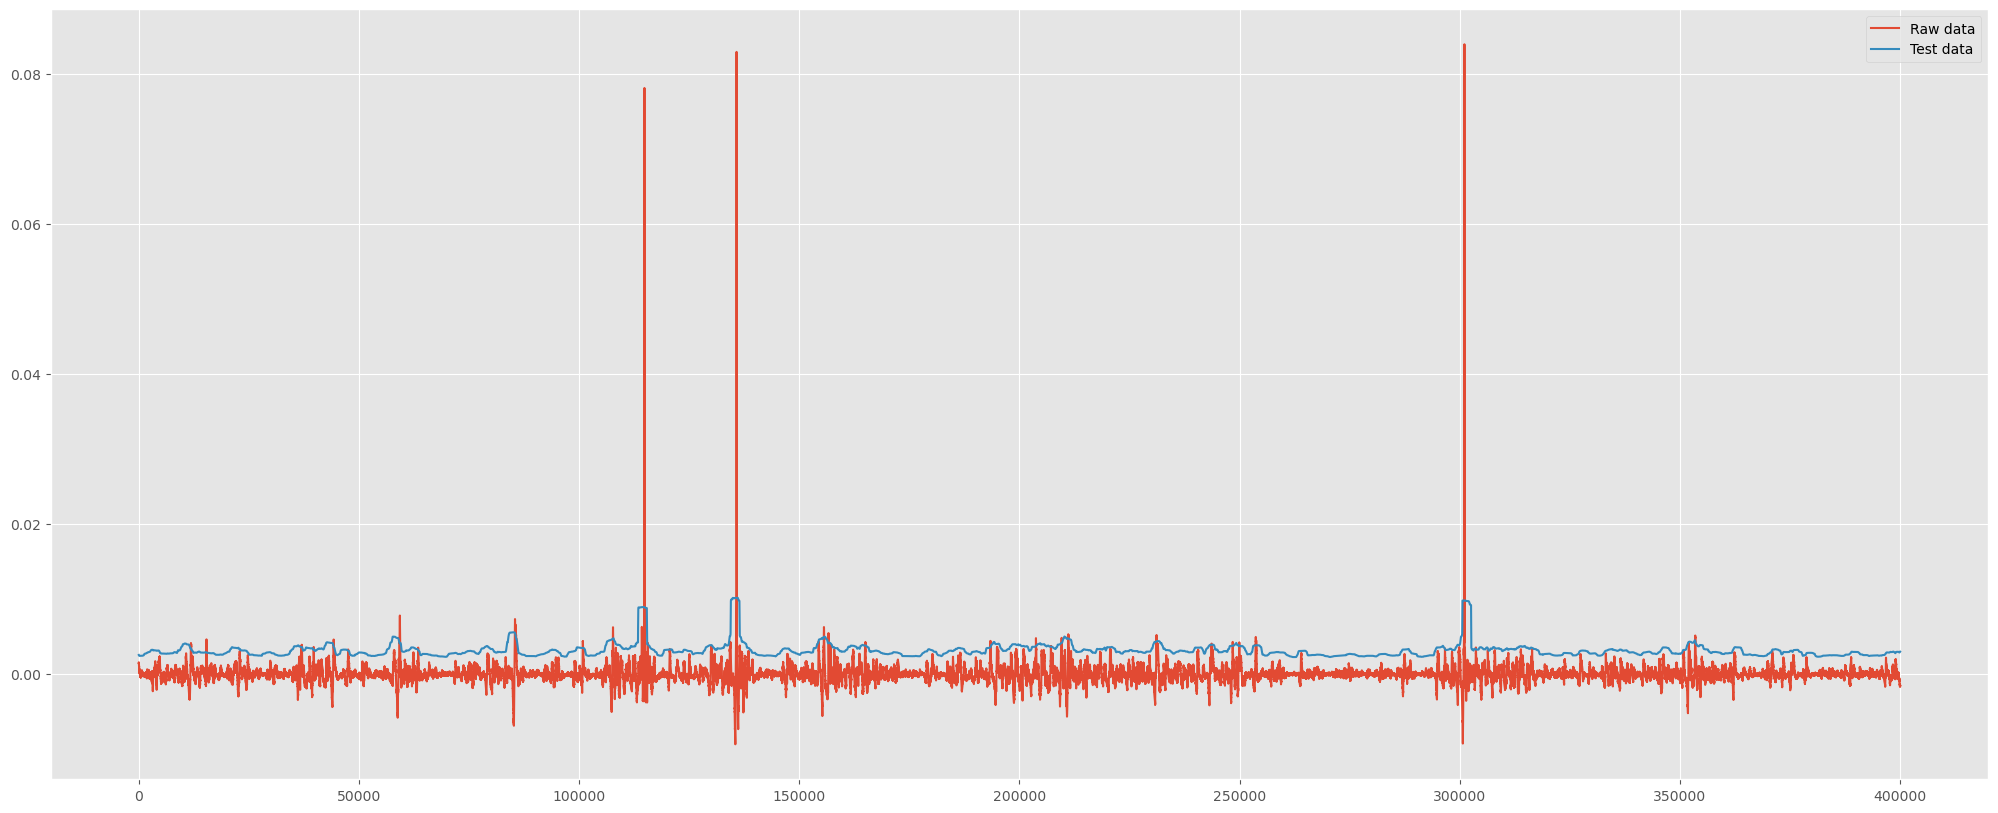

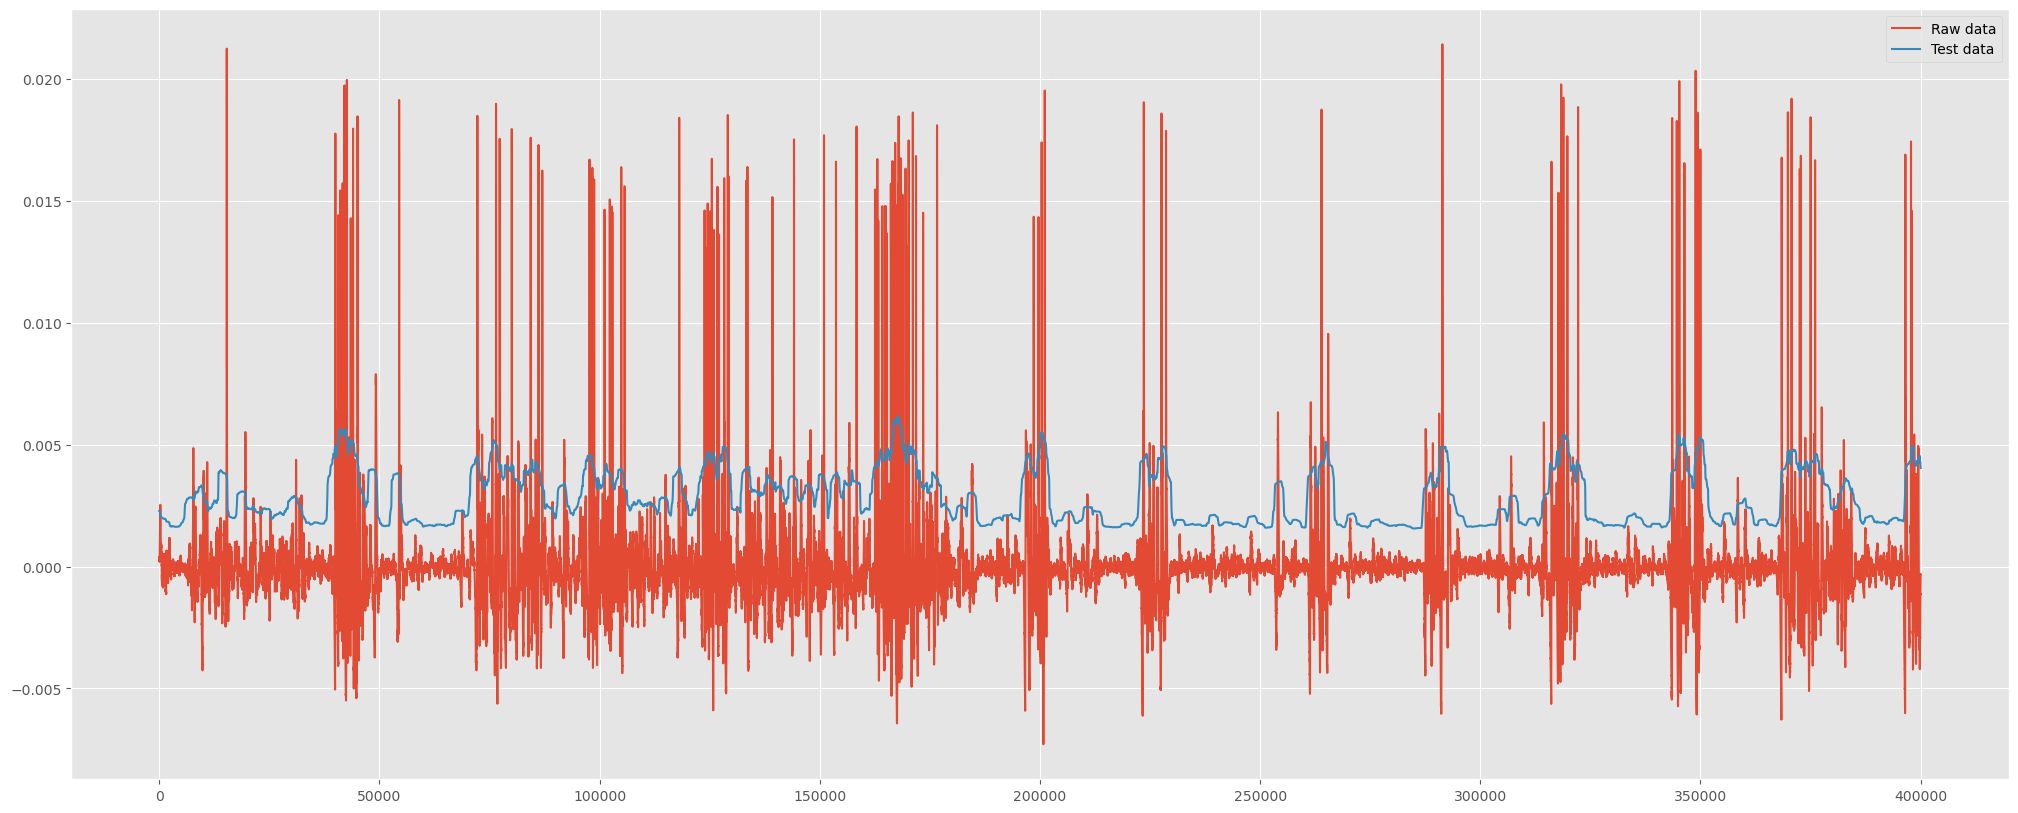

In [170]:
'''

*******************************************************************************************

'''

Vm_testplot(normalized_Vm, local_lower_bound(Vm))
Vm_testplot(moving_avg_normalise(Vm2), local_lower_bound(Vm2))

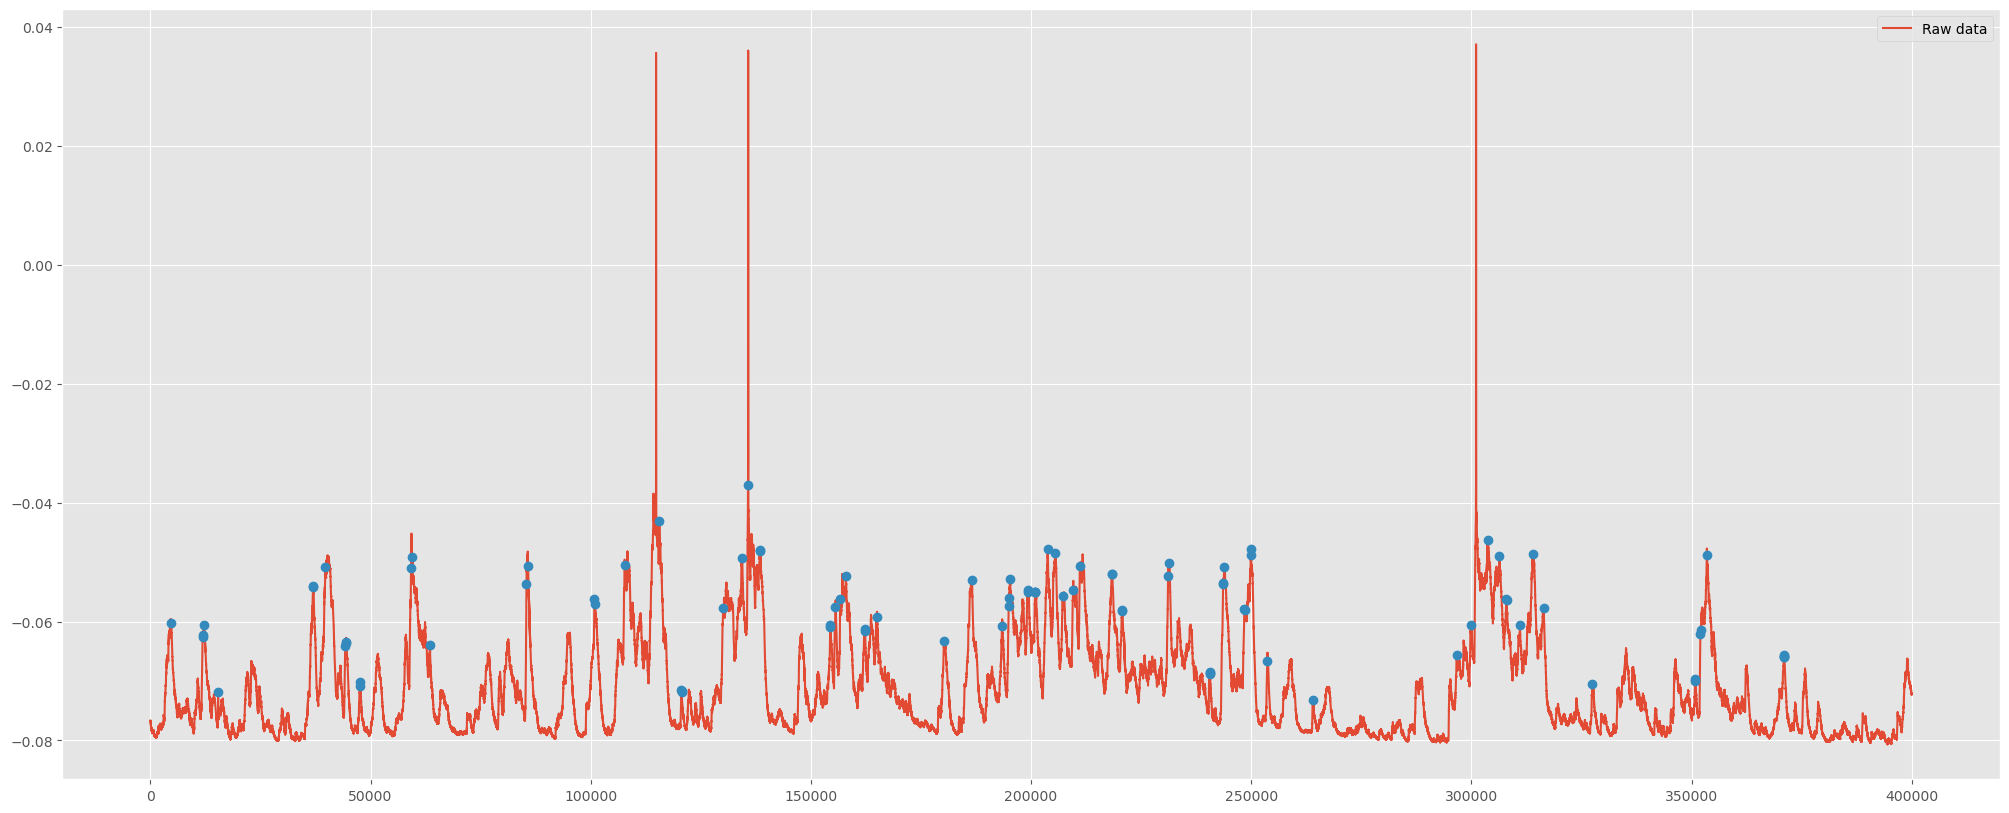

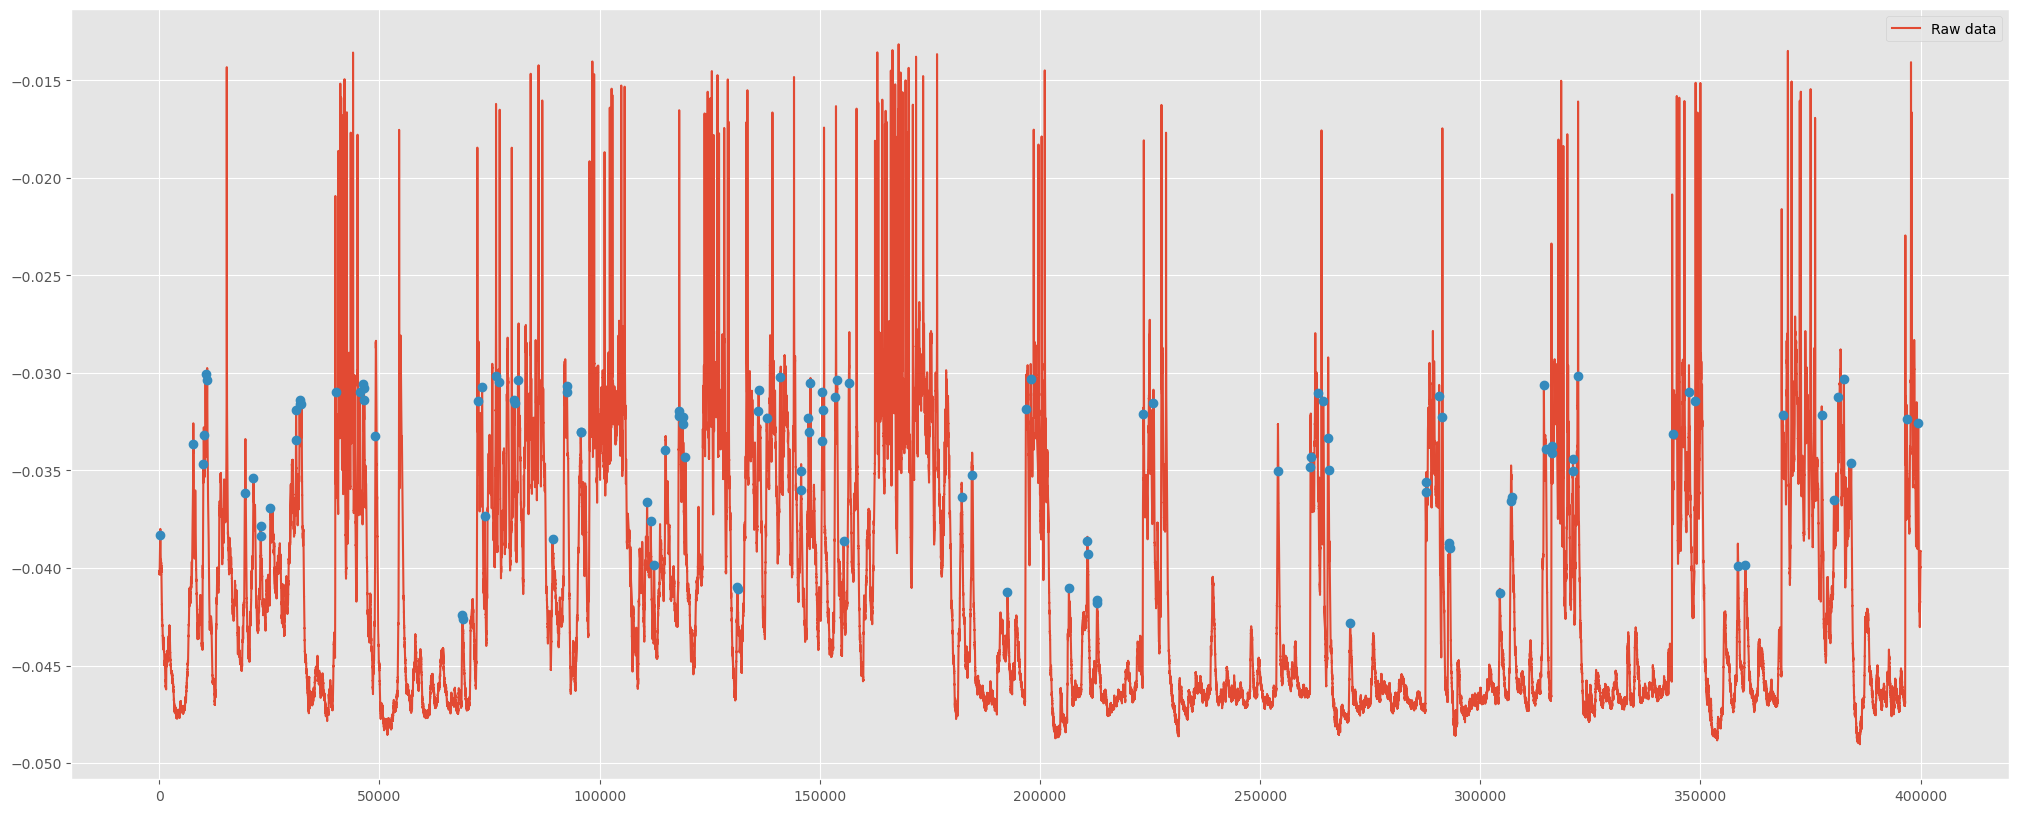

In [171]:
'''

*******************************************************************************************

'''

spikelet_testplot(Vm, find_spikelet_moving_avg(Vm, lower_threshold= local_lower_bound(Vm)))
spikelet_testplot(Vm2, find_spikelet_moving_avg(Vm2, lower_threshold= local_lower_bound(Vm2)))

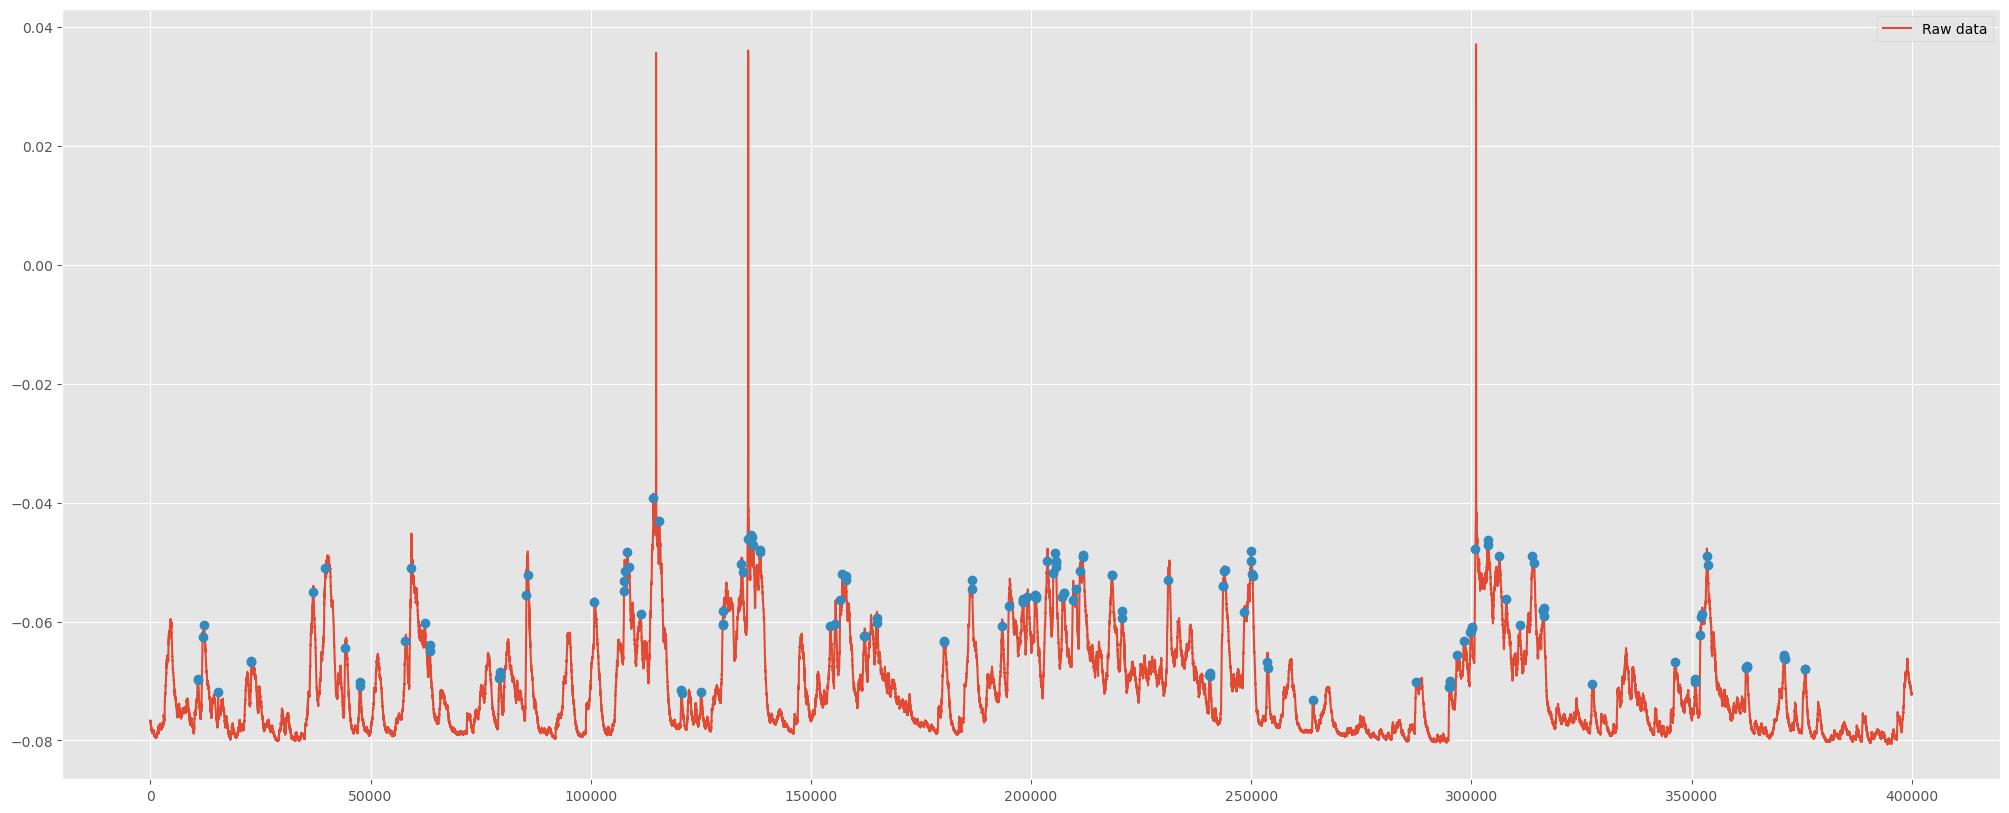

In [109]:
'''

*******************************************************************************************

'''

lower_threshold = 0.003
upper_threshold = 0.004
window_size = 1000

spikelets = find_spikelet_moving_avg(Vm, window_size=window_size, lower_threshold=lower_threshold, SR_Vm=sampling_rate)


spikelet_testplot(Vm, spikelets)

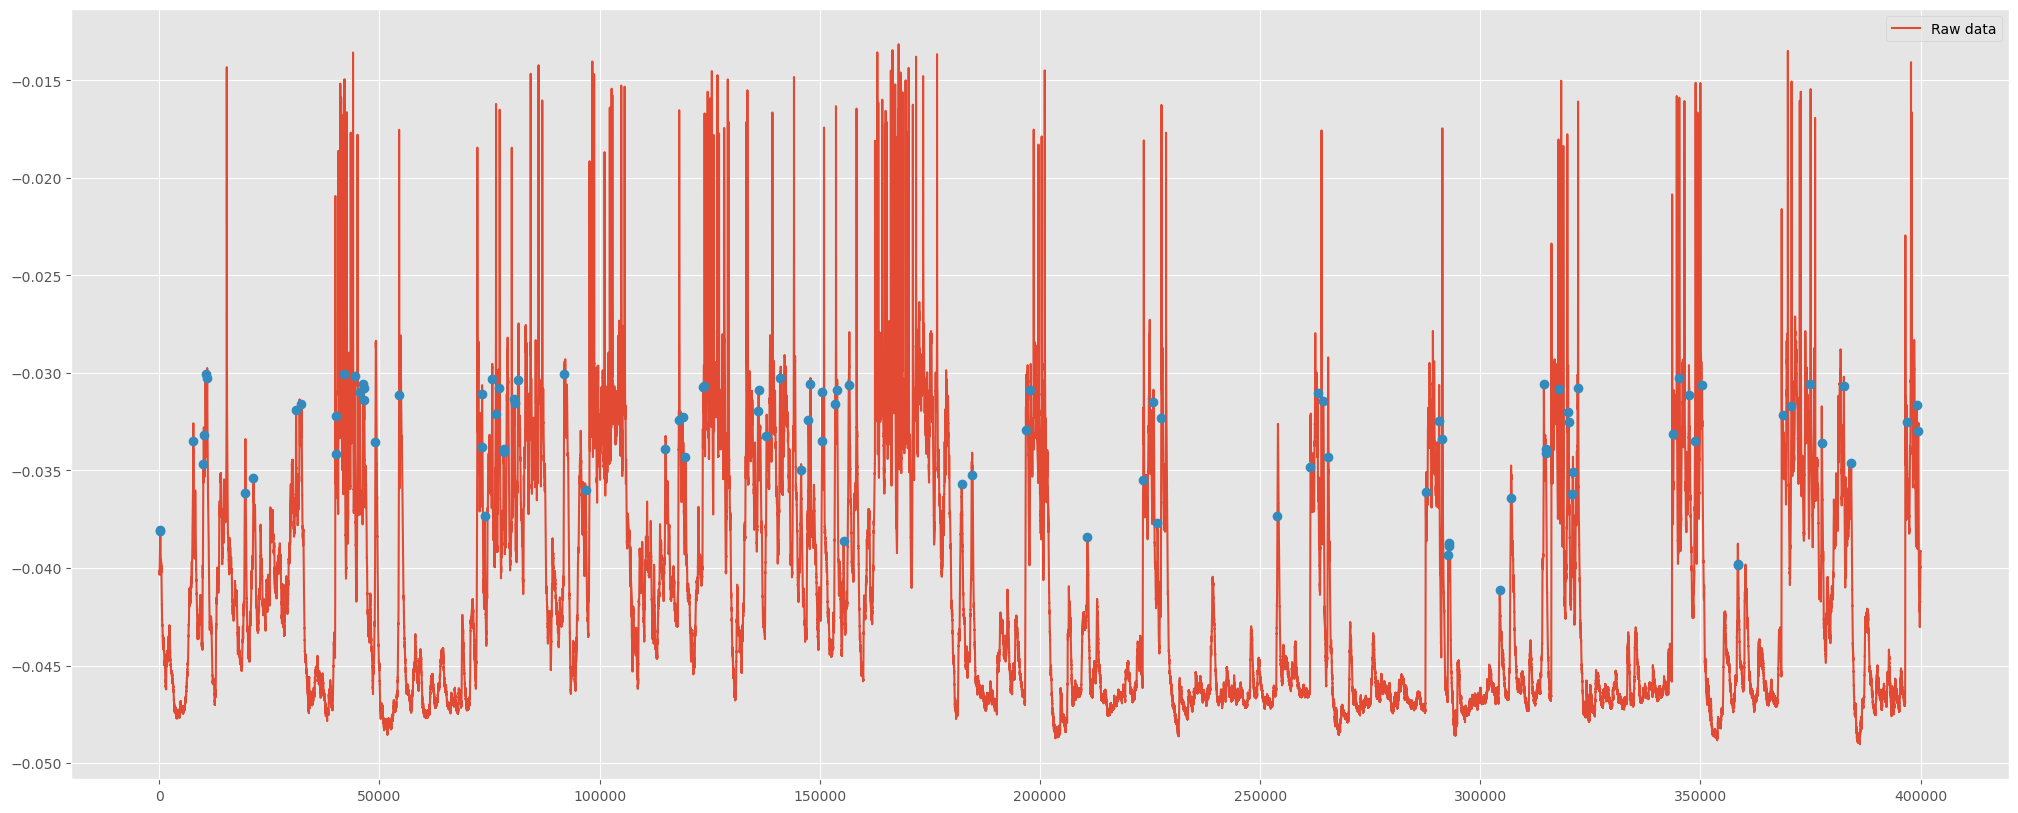

In [110]:

lower_threshold = 0.003
upper_threshold = 0.004
window_size = 1000

spikelets = find_spikelet_moving_avg(Vm2, window_size=window_size, lower_threshold=lower_threshold, SR_Vm=sampling_rate)


spikelet_testplot(Vm2, spikelets)

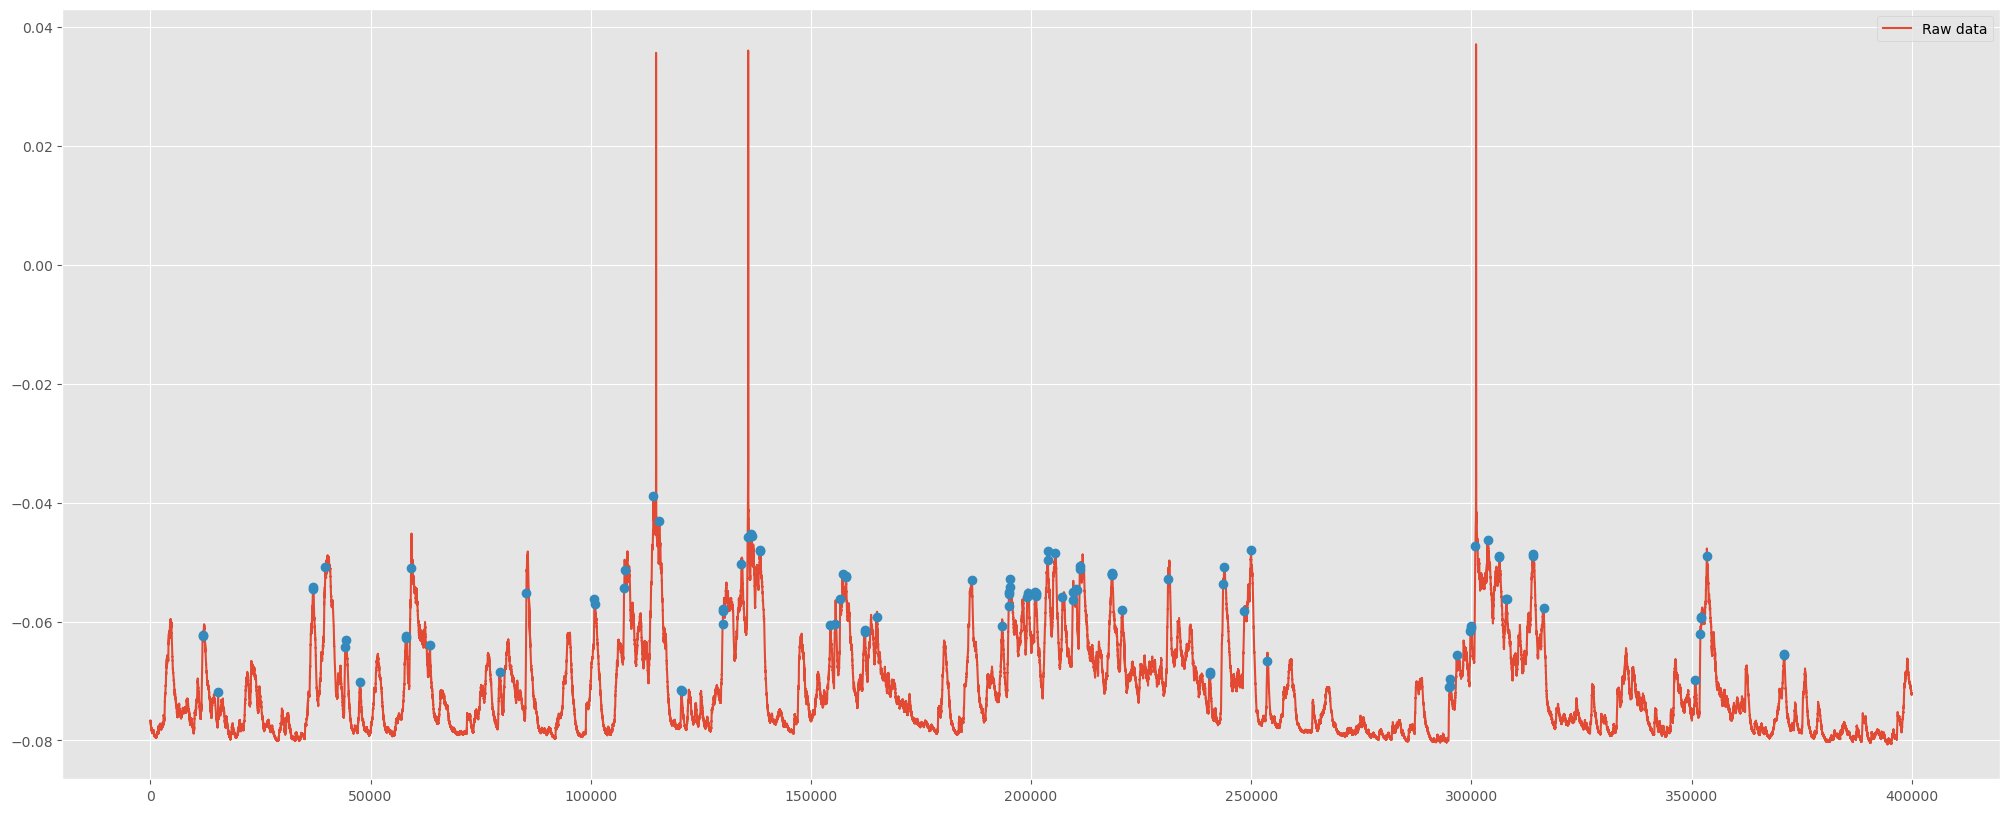

In [111]:



lower_threshold = lower_bound(Vm, mvg_avg_window = 1000, sub_window_size=20000)
upper_threshold = 0.004

spikelets = find_spikelet_moving_avg(Vm, window_size=window_size, lower_threshold=lower_threshold, SR_Vm=sampling_rate)

spikelet_testplot(Vm, spikelets)

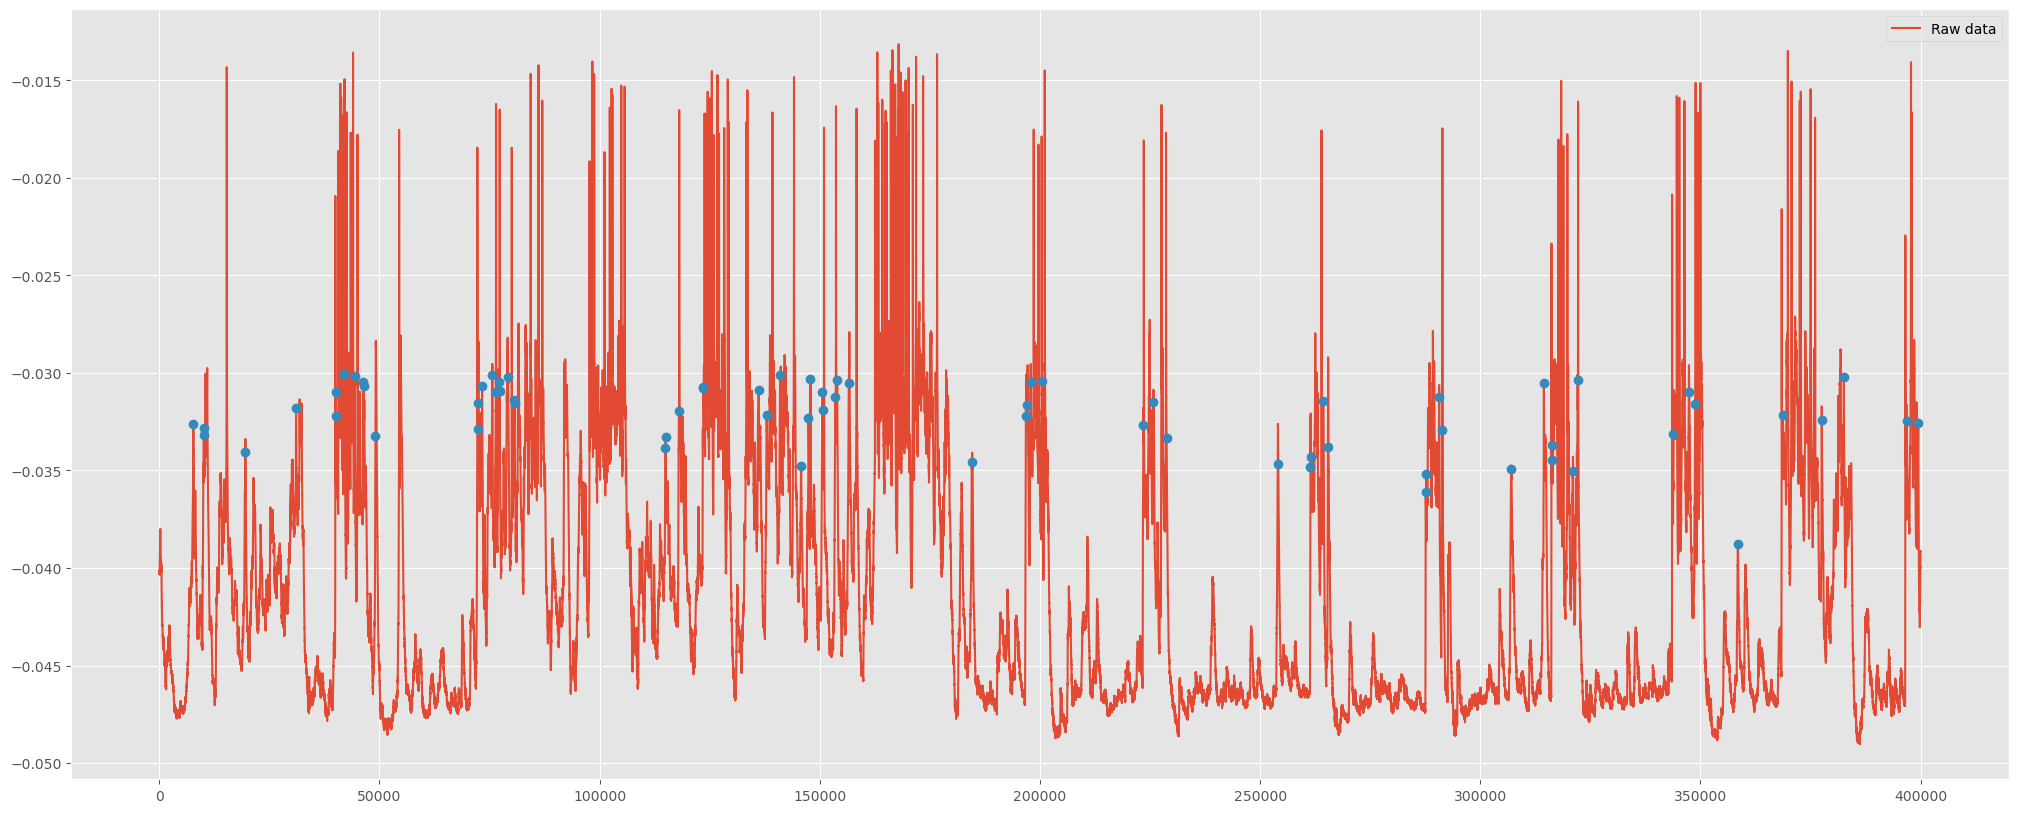

In [112]:



lower_threshold = lower_bound(Vm2,mvg_avg_window=1000, sub_window_size=20000)
upper_threshold = 0.004

spikelets = find_spikelet_moving_avg(Vm2, window_size=window_size, lower_threshold=lower_threshold, SR_Vm=sampling_rate)


spikelet_testplot(Vm2, spikelets)